In [1]:
import torch.optim as optim
from torch import nn

from preprocessing_last20 import *
from encoder import Encoder
from decoder import Decoder
from classifier import FaceRecognizer
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
from d2c_encoder import D2CEncoder
from d2c_decoder import D2CDecoder

In [2]:
device = torch.device('cpu')
train_data.to(device)
test_data.to(device)

classifier = FaceRecognizer().to(device)
vae_encoder = Encoder().to(device) # input 64*64 image, output 128 feacture vector
vae_decoder = Decoder().to(device) # input 128 feature vector, output 64*64 image
d2c_encoder = D2CEncoder().to(device)
d2c_decoder = D2CDecoder().to(device)
d2c_ddpm = DDPM(eps_model=NaiveUnet(16, 16, n_feat=128), betas=(1e-4, 0.02), n_T=200).to(device)
ddpm = DDPM(eps_model=NaiveUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), n_T=600).to(device)
attack_targets = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]).to(device)

In [3]:
classifier.load_state_dict(torch.load('classifier.pt'))
vae_encoder.load_state_dict(torch.load('train_VAE_last20encoder.pt'))
vae_decoder.load_state_dict(torch.load('train_VAE_last20decoder.pt'))
d2c_encoder.load_state_dict(torch.load('d2c_encoder.pth'))
d2c_decoder.load_state_dict(torch.load('d2c_decoder.pth'))
d2c_ddpm.load_state_dict(torch.load('d2c_ddpm.pth'))
ddpm.load_state_dict(torch.load('ddpm_batched_600_last20.pth'))

<All keys matched successfully>

In [4]:
def sample_ddpm(noise=None):
    ddpm.eval()
    for param in ddpm.parameters():
        param.requires_grad = False
    torch.random.manual_seed(0)
    xh = ddpm.sample(1, (1, 64, 64), device, noise)
    tensor_to_picture(xh[0].detach().cpu().numpy()[0])
    return xh

In [5]:
x_i = torch.randn(1, 1, 64, 64).to(device)

In [6]:
x_i.requires_grad = True

In [7]:
def optimize_ddpm_noise(noise, optimizer, criterion, target):
    optimizer.zero_grad()
    generated = sample_ddpm(noise)
    result = classifier(generated)
    loss = criterion(result,attack_targets[target])
    loss.backward()
    optimizer.step()
    return loss.item(), generated, result
def optimize_ddpm_noise_eps(noise, eps, lr, lr_decay, target=8):
    for epoch in range(eps): 
        optimizer = optim.SGD([noise], lr=lr*lr_decay**epoch, momentum=0.9, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss, generated, result = optimize_ddpm_noise(noise, optimizer, criterion, target)
        print("loss(generator): ", epoch_loss)
        print(torch.softmax(result,-1))

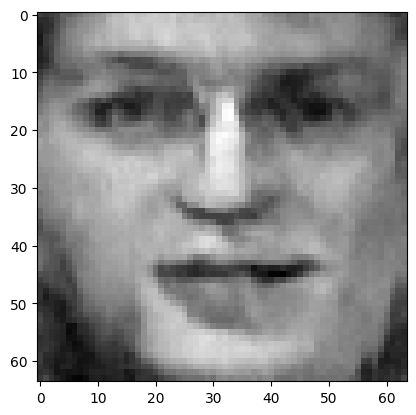

loss(generator):  8.297959327697754
tensor([[1.0298e-05, 3.9612e-05, 2.4902e-04, 4.1975e-05, 8.1979e-04, 7.7377e-08,
         3.4936e-02, 2.2706e-05, 3.3072e-03, 8.5164e-04, 7.7787e-05, 3.8751e-04,
         1.2775e-02, 2.3401e-05, 2.7184e-04, 9.6961e-03, 3.9614e-05, 3.3149e-03,
         7.2436e-04, 6.3382e-03, 5.5944e-03, 1.1692e-03, 5.4653e-07, 2.7609e-01,
         1.8575e-03, 2.7309e-08, 5.6251e-06, 1.4460e-04, 3.2571e-03, 1.0683e-01,
         5.1428e-03, 7.6039e-07, 3.0973e-02, 1.6339e-04, 1.9524e-02, 3.0348e-02,
         2.8100e-06, 6.3298e-04, 1.6170e-02, 4.2817e-01]],
       grad_fn=<SoftmaxBackward>)


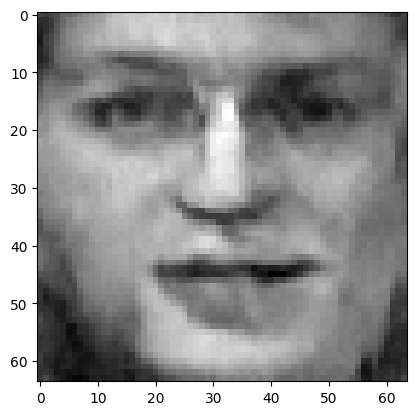

loss(generator):  7.256968021392822
tensor([[1.2396e-05, 8.8914e-05, 7.0524e-04, 7.7919e-05, 1.0161e-03, 5.9821e-08,
         3.3194e-02, 2.2162e-05, 2.8069e-03, 7.1196e-04, 1.0781e-04, 6.7448e-04,
         1.8740e-02, 9.9971e-05, 2.8789e-04, 5.3346e-03, 6.7889e-05, 1.4480e-03,
         8.6316e-04, 5.2670e-03, 1.5508e-02, 2.9470e-03, 7.8126e-07, 1.6553e-01,
         3.1221e-03, 1.3004e-07, 1.3404e-05, 3.4380e-04, 3.7722e-03, 9.1876e-02,
         1.5175e-02, 1.6189e-06, 3.4501e-02, 4.5782e-04, 1.7837e-02, 1.7108e-02,
         1.0891e-05, 1.3869e-03, 2.7504e-02, 5.3137e-01]],
       grad_fn=<SoftmaxBackward>)


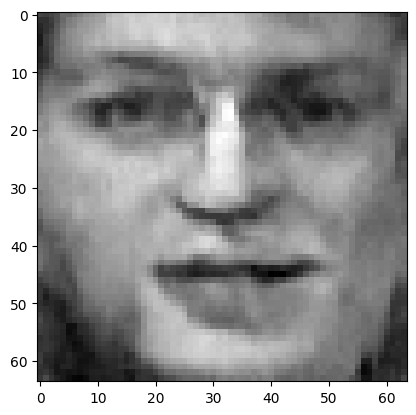

loss(generator):  6.592334747314453
tensor([[1.3974e-05, 1.5212e-04, 1.3708e-03, 1.1687e-04, 1.0575e-03, 4.4615e-08,
         3.3007e-02, 2.1833e-05, 2.2215e-03, 5.7373e-04, 1.2862e-04, 8.7473e-04,
         2.3468e-02, 2.6306e-04, 2.7185e-04, 3.2230e-03, 1.0087e-04, 6.9028e-04,
         9.1129e-04, 4.5144e-03, 3.0276e-02, 5.7986e-03, 8.7391e-07, 1.2036e-01,
         4.0940e-03, 3.7274e-07, 2.1983e-05, 6.2892e-04, 4.1262e-03, 7.4873e-02,
         3.1700e-02, 2.4652e-06, 3.6710e-02, 9.5547e-04, 1.7291e-02, 1.1654e-02,
         2.8902e-05, 2.1994e-03, 4.2531e-02, 5.4377e-01]],
       grad_fn=<SoftmaxBackward>)


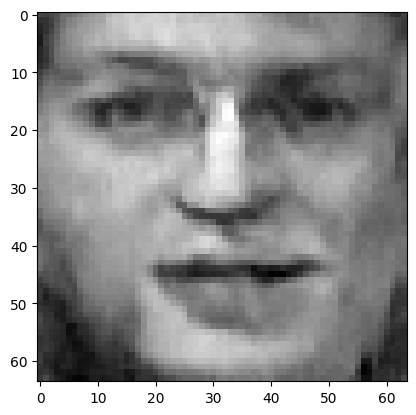

loss(generator):  6.113803863525391
tensor([[1.5386e-05, 2.2501e-04, 2.2121e-03, 1.5533e-04, 1.0635e-03, 3.4784e-08,
         3.3799e-02, 2.1616e-05, 1.7779e-03, 4.7029e-04, 1.4336e-04, 1.0254e-03,
         2.7139e-02, 5.4446e-04, 2.4307e-04, 2.1067e-03, 1.4187e-04, 3.6241e-04,
         9.1131e-04, 3.9046e-03, 4.9104e-02, 1.0048e-02, 9.1537e-07, 9.3937e-02,
         4.9312e-03, 8.4246e-07, 3.0652e-05, 1.0083e-03, 4.3625e-03, 6.0594e-02,
         5.6097e-02, 3.3563e-06, 3.8551e-02, 1.6831e-03, 1.7104e-02, 8.7332e-03,
         6.3354e-05, 3.0706e-03, 6.0246e-02, 5.1417e-01]],
       grad_fn=<SoftmaxBackward>)


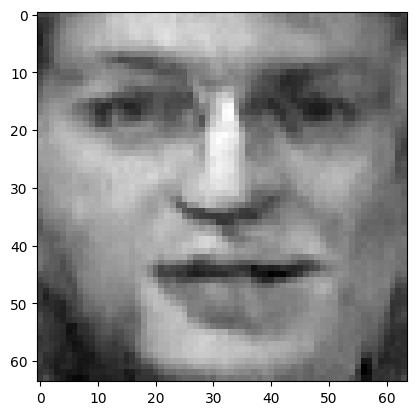

loss(generator):  5.750222206115723
tensor([[1.6812e-05, 2.9093e-04, 3.1821e-03, 1.8971e-04, 1.0383e-03, 2.8800e-08,
         3.4489e-02, 2.1411e-05, 1.4628e-03, 4.0179e-04, 1.5166e-04, 1.1558e-03,
         2.9397e-02, 9.3810e-04, 2.0911e-04, 1.4534e-03, 1.8686e-04, 2.1445e-04,
         8.9480e-04, 3.3255e-03, 6.8471e-02, 1.4945e-02, 9.5554e-07, 7.4523e-02,
         5.6107e-03, 1.6167e-06, 3.8985e-05, 1.4420e-03, 4.3941e-03, 4.8209e-02,
         8.3871e-02, 4.1974e-06, 3.8403e-02, 2.4820e-03, 1.6698e-02, 6.7566e-03,
         1.1628e-04, 3.9327e-03, 7.5244e-02, 4.7584e-01]],
       grad_fn=<SoftmaxBackward>)


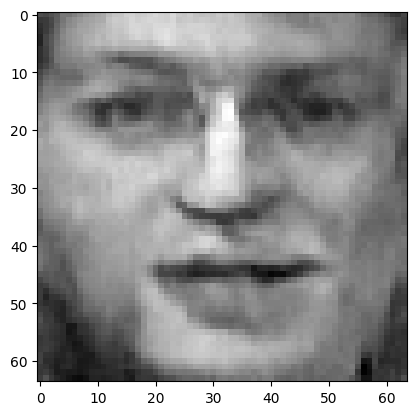

loss(generator):  5.449194431304932
tensor([[1.8481e-05, 3.4831e-04, 4.2998e-03, 2.2313e-04, 9.9856e-04, 2.5049e-08,
         3.5084e-02, 2.1367e-05, 1.2347e-03, 3.5712e-04, 1.5669e-04, 1.2942e-03,
         3.0709e-02, 1.4513e-03, 1.7755e-04, 1.0394e-03, 2.3812e-04, 1.3834e-04,
         8.7994e-04, 2.8053e-03, 8.7228e-02, 2.0235e-02, 1.0202e-06, 5.9776e-02,
         6.2059e-03, 2.8515e-06, 4.7548e-05, 1.9335e-03, 4.3074e-03, 3.7752e-02,
         1.1222e-01, 5.0498e-06, 3.6864e-02, 3.2713e-03, 1.6171e-02, 5.2995e-03,
         1.9307e-04, 4.8194e-03, 8.6407e-02, 4.3578e-01]],
       grad_fn=<SoftmaxBackward>)


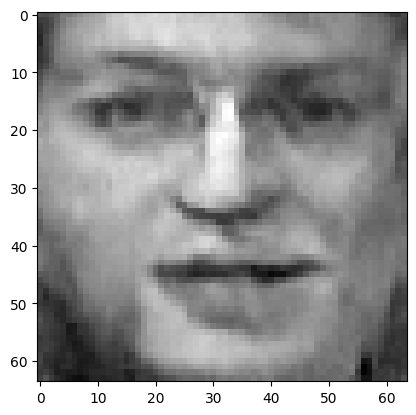

loss(generator):  5.195500373840332
tensor([[2.0322e-05, 3.9472e-04, 5.5414e-03, 2.5487e-04, 9.5120e-04, 2.2455e-08,
         3.5708e-02, 2.1234e-05, 1.0625e-03, 3.2471e-04, 1.5827e-04, 1.4135e-03,
         3.1421e-02, 2.0603e-03, 1.5039e-04, 7.6457e-04, 2.9240e-04, 9.4493e-05,
         8.6253e-04, 2.3615e-03, 1.0429e-01, 2.5690e-02, 1.0990e-06, 4.8446e-02,
         6.7308e-03, 4.6384e-06, 5.5594e-05, 2.4697e-03, 4.1913e-03, 2.9549e-02,
         1.3881e-01, 5.8651e-06, 3.4847e-02, 3.9879e-03, 1.5541e-02, 4.2367e-03,
         2.9637e-04, 5.7160e-03, 9.4168e-02, 3.9711e-01]],
       grad_fn=<SoftmaxBackward>)


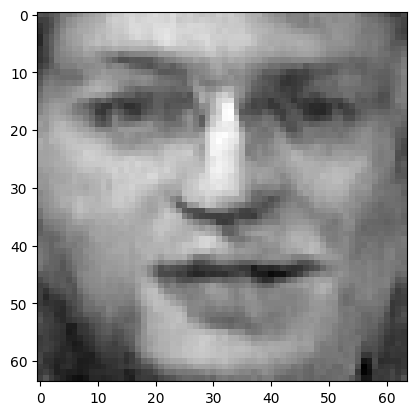

loss(generator):  4.97400426864624
tensor([[2.2546e-05, 4.2631e-04, 6.9154e-03, 2.8491e-04, 8.9673e-04, 2.0870e-08,
         3.6393e-02, 2.1185e-05, 9.4459e-04, 3.0500e-04, 1.5783e-04, 1.5136e-03,
         3.1784e-02, 2.7036e-03, 1.2793e-04, 5.8756e-04, 3.4718e-04, 6.9124e-05,
         8.4774e-04, 2.0121e-03, 1.1878e-01, 3.0521e-02, 1.1966e-06, 4.0003e-02,
         7.1881e-03, 6.9226e-06, 6.2944e-05, 3.0260e-03, 4.1153e-03, 2.3437e-02,
         1.5890e-01, 6.5413e-06, 3.2662e-02, 4.5218e-03, 1.4909e-02, 3.4493e-03,
         4.2223e-04, 6.6226e-03, 9.8091e-02, 3.6691e-01]],
       grad_fn=<SoftmaxBackward>)


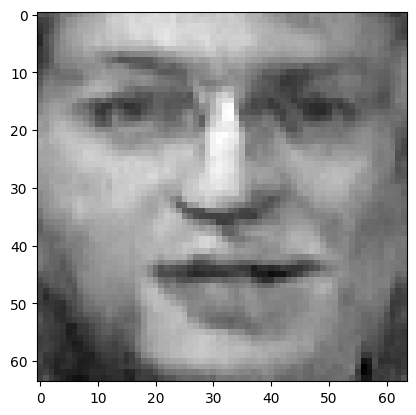

loss(generator):  4.767795562744141
tensor([[2.5389e-05, 4.5059e-04, 8.4991e-03, 3.1539e-04, 8.4502e-04, 2.0114e-08,
         3.7301e-02, 2.1395e-05, 8.6014e-04, 2.9377e-04, 1.5779e-04, 1.6241e-03,
         3.1999e-02, 3.4230e-03, 1.0974e-04, 4.6587e-04, 4.0780e-04, 5.3469e-05,
         8.3983e-04, 1.7222e-03, 1.3155e-01, 3.4839e-02, 1.3314e-06, 3.3398e-02,
         7.6918e-03, 9.9688e-06, 7.0705e-05, 3.6386e-03, 4.0643e-03, 1.8700e-02,
         1.7379e-01, 7.2524e-06, 3.0385e-02, 4.9138e-03, 1.4330e-02, 2.8336e-03,
         5.7920e-04, 7.6471e-03, 9.9292e-02, 3.4285e-01]],
       grad_fn=<SoftmaxBackward>)


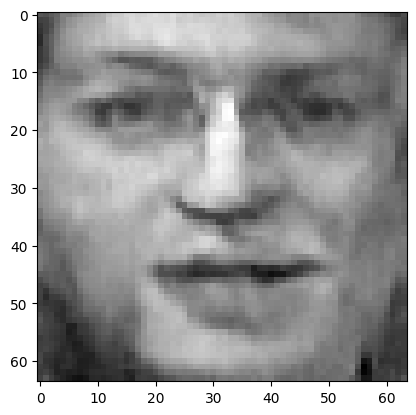

loss(generator):  4.570577144622803
tensor([[2.8522e-05, 4.7082e-04, 1.0352e-02, 3.4652e-04, 7.8179e-04, 1.9361e-08,
         3.8157e-02, 2.1687e-05, 7.8842e-04, 2.8498e-04, 1.5742e-04, 1.7105e-03,
         3.2115e-02, 4.1988e-03, 9.4197e-05, 3.7449e-04, 4.7316e-04, 4.1454e-05,
         8.3101e-04, 1.4924e-03, 1.4278e-01, 3.9372e-02, 1.4644e-06, 2.8194e-02,
         8.0887e-03, 1.3761e-05, 7.8204e-05, 4.3191e-03, 4.0798e-03, 1.5035e-02,
         1.8563e-01, 7.8305e-06, 2.8337e-02, 5.2453e-03, 1.3738e-02, 2.3456e-03,
         7.7739e-04, 8.7230e-03, 9.9867e-02, 3.2065e-01]],
       grad_fn=<SoftmaxBackward>)


In [10]:
optimize_ddpm_noise_eps(x_i, 10, 0.1, 1, target=2)

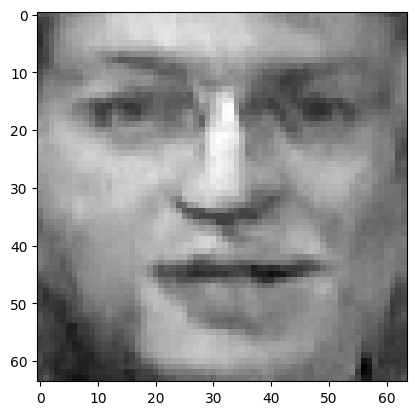

loss(generator):  4.380500793457031
tensor([[3.2448e-05, 4.8513e-04, 1.2519e-02, 3.7745e-04, 7.2201e-04, 1.9027e-08,
         3.9182e-02, 2.2130e-05, 7.3685e-04, 2.8216e-04, 1.5722e-04, 1.7964e-03,
         3.2288e-02, 5.0134e-03, 8.1173e-05, 3.0797e-04, 5.4582e-04, 3.3180e-05,
         8.2503e-04, 1.3037e-03, 1.5219e-01, 4.3541e-02, 1.6297e-06, 2.4006e-02,
         8.5019e-03, 1.8385e-05, 8.5911e-05, 5.0724e-03, 4.1459e-03, 1.2210e-02,
         1.9297e-01, 8.3472e-06, 2.6431e-02, 5.4506e-03, 1.3220e-02, 1.9589e-03,
         1.0197e-03, 9.9326e-03, 9.8845e-02, 3.0368e-01]],
       grad_fn=<SoftmaxBackward>)


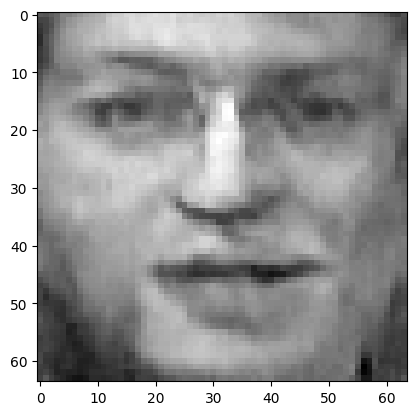

loss(generator):  4.006173133850098
tensor([[4.1403e-05, 5.0392e-04, 1.8203e-02, 4.4498e-04, 5.9236e-04, 1.7871e-08,
         4.1464e-02, 2.2959e-05, 6.4515e-04, 2.7897e-04, 1.5551e-04, 1.8868e-03,
         3.2801e-02, 6.8015e-03, 5.9583e-05, 2.1020e-04, 7.2306e-04, 2.0673e-05,
         8.0548e-04, 1.0131e-03, 1.6877e-01, 5.3853e-02, 1.9769e-06, 1.7652e-02,
         9.0771e-03, 3.0410e-05, 1.0071e-04, 6.9365e-03, 4.4379e-03, 8.0931e-03,
         2.0248e-01, 8.9704e-06, 2.3376e-02, 5.7895e-03, 1.2222e-02, 1.3853e-03,
         1.7371e-03, 1.2562e-02, 9.7374e-02, 2.6743e-01]],
       grad_fn=<SoftmaxBackward>)


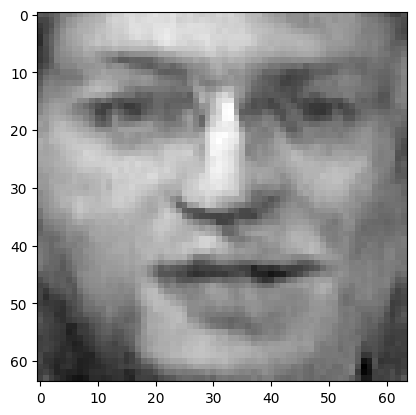

loss(generator):  3.6440725326538086
tensor([[5.3777e-05, 5.0956e-04, 2.6146e-02, 5.1296e-04, 4.7743e-04, 1.7233e-08,
         4.4373e-02, 2.4091e-05, 5.8721e-04, 2.8812e-04, 1.5429e-04, 1.9405e-03,
         3.3920e-02, 8.6766e-03, 4.3504e-05, 1.5268e-04, 9.5006e-04, 1.3546e-05,
         7.8933e-04, 8.0589e-04, 1.7919e-01, 6.4510e-02, 2.4025e-06, 1.3279e-02,
         9.5876e-03, 4.5594e-05, 1.1642e-04, 9.3040e-03, 4.9432e-03, 5.5129e-03,
         2.0099e-01, 9.2611e-06, 2.0913e-02, 5.8349e-03, 1.1293e-02, 1.0039e-03,
         2.8162e-03, 1.5729e-02, 9.3343e-02, 2.4115e-01]],
       grad_fn=<SoftmaxBackward>)


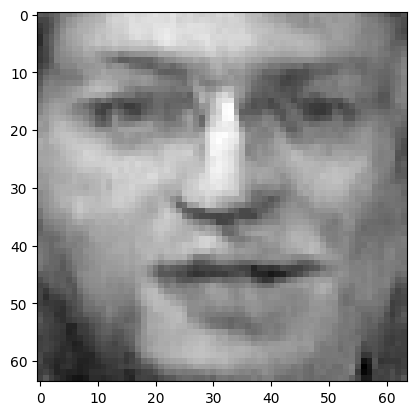

loss(generator):  3.285984516143799
tensor([[6.9837e-05, 5.0213e-04, 3.7404e-02, 5.7945e-04, 3.7399e-04, 1.6605e-08,
         4.7604e-02, 2.5184e-05, 5.4696e-04, 3.0510e-04, 1.5272e-04, 1.9258e-03,
         3.5440e-02, 1.0473e-02, 3.1396e-05, 1.1643e-04, 1.2299e-03, 9.0179e-06,
         7.6961e-04, 6.5682e-04, 1.8475e-01, 7.5573e-02, 2.8647e-06, 1.0145e-02,
         9.9017e-03, 6.1749e-05, 1.3190e-04, 1.2270e-02, 5.7265e-03, 3.8393e-03,
         1.9065e-01, 9.0499e-06, 1.8909e-02, 5.6702e-03, 1.0379e-02, 7.3946e-04,
         4.3815e-03, 1.9324e-02, 8.7787e-02, 2.2153e-01]],
       grad_fn=<SoftmaxBackward>)


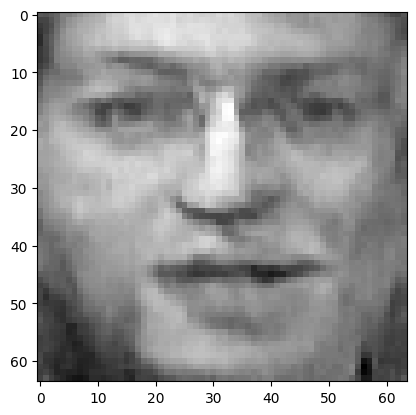

loss(generator):  2.926250457763672
tensor([[8.9661e-05, 4.8374e-04, 5.3598e-02, 6.4974e-04, 2.8153e-04, 1.5776e-08,
         5.1130e-02, 2.6133e-05, 5.1529e-04, 3.2612e-04, 1.5045e-04, 1.8312e-03,
         3.6980e-02, 1.2092e-02, 2.2358e-05, 9.0823e-05, 1.5752e-03, 5.9269e-06,
         7.4565e-04, 5.4424e-04, 1.8628e-01, 8.7662e-02, 3.3482e-06, 7.8124e-03,
         9.9743e-03, 7.7317e-05, 1.4644e-04, 1.6028e-02, 6.8678e-03, 2.6848e-03,
         1.7405e-01, 8.3794e-06, 1.7196e-02, 5.3779e-03, 9.4615e-03, 5.4617e-04,
         6.6733e-03, 2.3229e-02, 8.1670e-02, 2.0312e-01]],
       grad_fn=<SoftmaxBackward>)


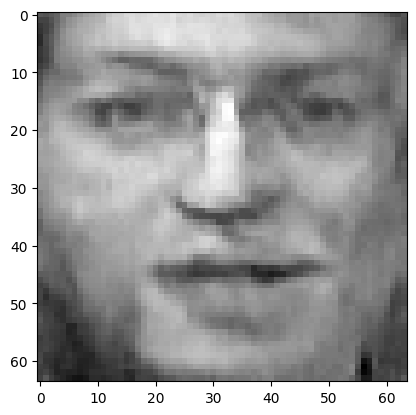

loss(generator):  2.5776939392089844
tensor([[1.1621e-04, 4.5415e-04, 7.5949e-02, 7.1165e-04, 2.1076e-04, 1.5522e-08,
         5.4418e-02, 2.7428e-05, 4.9852e-04, 3.5709e-04, 1.4812e-04, 1.7220e-03,
         3.8557e-02, 1.3436e-02, 1.5917e-05, 7.4114e-05, 1.9653e-03, 4.1089e-06,
         7.1843e-04, 4.5660e-04, 1.8282e-01, 9.6269e-02, 3.9155e-06, 6.0411e-03,
         1.0035e-02, 9.0905e-05, 1.5982e-04, 2.0426e-02, 8.3205e-03, 1.9175e-03,
         1.5085e-01, 7.5040e-06, 1.5553e-02, 4.8793e-03, 8.6228e-03, 4.0702e-04,
         9.6282e-03, 2.7789e-02, 7.3497e-02, 1.9285e-01]],
       grad_fn=<SoftmaxBackward>)


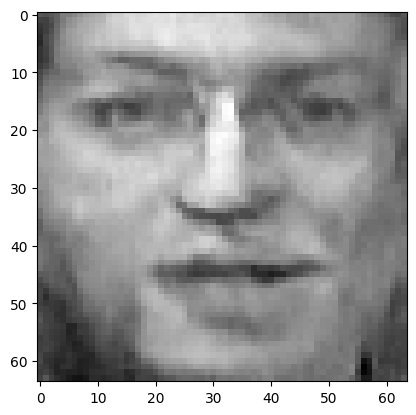

loss(generator):  2.2425127029418945
tensor([[1.4379e-04, 4.1253e-04, 1.0619e-01, 7.6222e-04, 1.4934e-04, 1.4617e-08,
         5.7117e-02, 2.8397e-05, 4.8102e-04, 3.9119e-04, 1.4411e-04, 1.5009e-03,
         3.9922e-02, 1.3926e-02, 1.1153e-05, 6.2344e-05, 2.3764e-03, 2.7434e-06,
         6.7769e-04, 3.9494e-04, 1.7434e-01, 1.0481e-01, 4.3063e-06, 4.7287e-03,
         9.6022e-03, 9.4788e-05, 1.6674e-04, 2.5420e-02, 1.0445e-02, 1.3962e-03,
         1.2489e-01, 6.1710e-06, 1.4292e-02, 4.3438e-03, 7.7617e-03, 3.0655e-04,
         1.3240e-02, 3.1815e-02, 6.5756e-02, 1.8189e-01]],
       grad_fn=<SoftmaxBackward>)


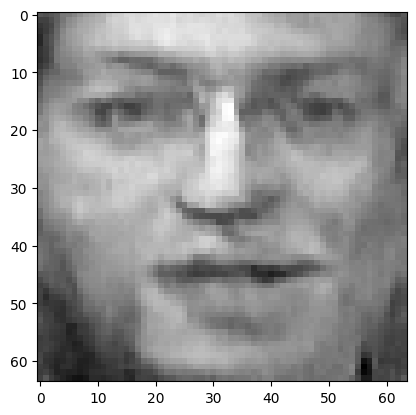

loss(generator):  1.9287153482437134
tensor([[1.7255e-04, 3.6468e-04, 1.4533e-01, 8.0054e-04, 1.0225e-04, 1.3389e-08,
         5.8668e-02, 2.9031e-05, 4.5438e-04, 4.2165e-04, 1.3763e-04, 1.2541e-03,
         4.0729e-02, 1.3893e-02, 7.6574e-06, 5.2046e-05, 2.8122e-03, 1.7736e-06,
         6.2391e-04, 3.3869e-04, 1.6196e-01, 1.1206e-01, 4.5906e-06, 3.6623e-03,
         8.9090e-03, 9.3951e-05, 1.6874e-04, 3.0983e-02, 1.3045e-02, 9.9958e-04,
         9.9944e-02, 4.8728e-06, 1.2961e-02, 3.7814e-03, 6.8409e-03, 2.2746e-04,
         1.7716e-02, 3.5229e-02, 5.7923e-02, 1.6729e-01]],
       grad_fn=<SoftmaxBackward>)


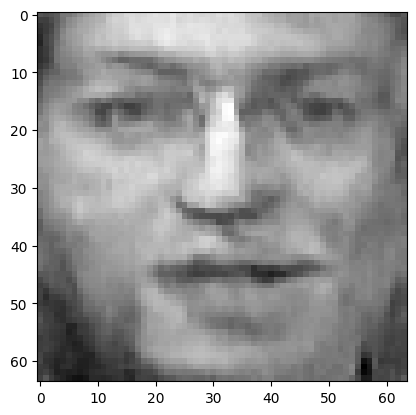

loss(generator):  1.65137779712677
tensor([[2.0507e-04, 3.1302e-04, 1.9179e-01, 8.1864e-04, 7.1229e-05, 1.2616e-08,
         5.9506e-02, 2.9629e-05, 4.3049e-04, 4.5199e-04, 1.2880e-04, 1.0491e-03,
         4.1103e-02, 1.3431e-02, 5.2668e-06, 4.4326e-05, 3.2150e-03, 1.2084e-06,
         5.6507e-04, 2.8776e-04, 1.4649e-01, 1.1305e-01, 4.8543e-06, 2.8374e-03,
         8.2257e-03, 9.0226e-05, 1.6638e-04, 3.6238e-02, 1.5738e-02, 7.2044e-04,
         7.7373e-02, 3.8215e-06, 1.1593e-02, 3.1613e-03, 5.9874e-03, 1.6935e-04,
         2.2197e-02, 3.8272e-02, 4.9465e-02, 1.5477e-01]],
       grad_fn=<SoftmaxBackward>)


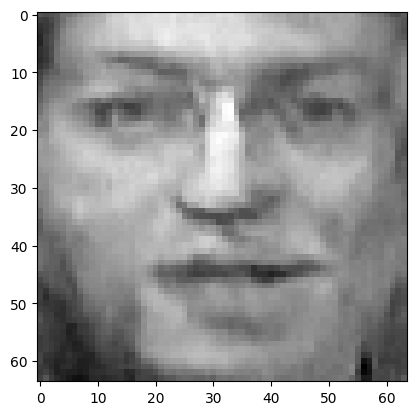

loss(generator):  1.410798192024231
tensor([[2.3757e-04, 2.6236e-04, 2.4395e-01, 8.1878e-04, 5.0322e-05, 1.1931e-08,
         5.9097e-02, 2.9867e-05, 4.0096e-04, 4.7155e-04, 1.1765e-04, 8.7480e-04,
         4.0830e-02, 1.2713e-02, 3.6485e-06, 3.7624e-05, 3.5725e-03, 8.4401e-07,
         5.0089e-04, 2.4135e-04, 1.3091e-01, 1.0920e-01, 5.0443e-06, 2.1977e-03,
         7.4555e-03, 8.5186e-05, 1.5927e-04, 4.0781e-02, 1.8168e-02, 5.1569e-04,
         5.9223e-02, 2.9731e-06, 1.0208e-02, 2.5822e-03, 5.2025e-03, 1.2594e-04,
         2.6535e-02, 4.0231e-02, 4.1840e-02, 1.4036e-01]],
       grad_fn=<SoftmaxBackward>)


In [11]:
optimize_ddpm_noise_eps(x_i, 10, 0.2, 1, target=2)

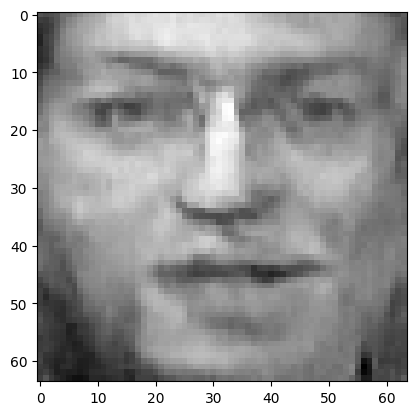

loss(generator):  1.2091552019119263
tensor([[2.6669e-04, 2.1683e-04, 2.9845e-01, 8.0169e-04, 3.5974e-05, 1.1224e-08,
         5.7363e-02, 2.9781e-05, 3.7031e-04, 4.8384e-04, 1.0602e-04, 7.2420e-04,
         3.9966e-02, 1.1719e-02, 2.5652e-06, 3.2300e-05, 3.8283e-03, 6.0546e-07,
         4.3811e-04, 2.0317e-04, 1.1590e-01, 1.0212e-01, 5.1066e-06, 1.7185e-03,
         6.6226e-03, 7.7829e-05, 1.4876e-04, 4.4230e-02, 2.0355e-02, 3.7459e-04,
         4.4817e-02, 2.2841e-06, 8.9278e-03, 2.0799e-03, 4.4957e-03, 9.4543e-05,
         3.0082e-02, 4.1032e-02, 3.5147e-02, 1.2674e-01]],
       grad_fn=<SoftmaxBackward>)


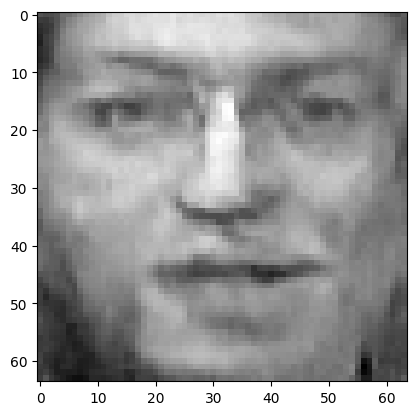

loss(generator):  1.0424199104309082
tensor([[2.9516e-04, 1.7769e-04, 3.5260e-01, 7.7582e-04, 2.6568e-05, 1.0665e-08,
         5.5038e-02, 2.9418e-05, 3.3982e-04, 4.8785e-04, 9.4146e-05, 6.1455e-04,
         3.8503e-02, 1.0802e-02, 1.8330e-06, 2.7633e-05, 4.0135e-03, 4.5147e-07,
         3.8137e-04, 1.6877e-04, 1.0251e-01, 9.2564e-02, 5.1721e-06, 1.3522e-03,
         5.8907e-03, 7.2334e-05, 1.3769e-04, 4.6670e-02, 2.1743e-02, 2.7186e-04,
         3.4052e-02, 1.7972e-06, 7.6814e-03, 1.6583e-03, 3.8777e-03, 7.1238e-05,
         3.2967e-02, 4.1104e-02, 2.9248e-02, 1.1375e-01]],
       grad_fn=<SoftmaxBackward>)


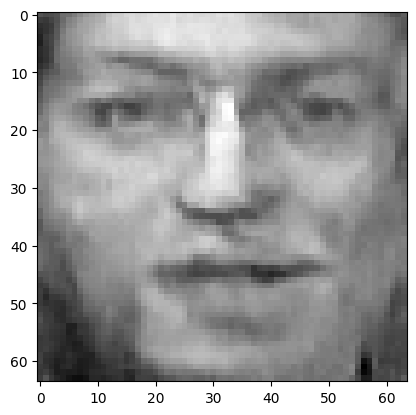

loss(generator):  0.9045627117156982
tensor([[3.1797e-04, 1.4472e-04, 4.0472e-01, 7.4735e-04, 1.9984e-05, 1.0051e-08,
         5.2099e-02, 2.8878e-05, 3.0999e-04, 4.8584e-04, 8.2897e-05, 5.2480e-04,
         3.6677e-02, 9.8457e-03, 1.3360e-06, 2.3798e-05, 4.1150e-03, 3.4376e-07,
         3.3165e-04, 1.4130e-04, 9.1042e-02, 8.2621e-02, 5.1478e-06, 1.0812e-03,
         5.1735e-03, 6.6559e-05, 1.2592e-04, 4.8026e-02, 2.2626e-02, 1.9992e-04,
         2.5945e-02, 1.4182e-06, 6.6070e-03, 1.3258e-03, 3.3566e-03, 5.4371e-05,
         3.5003e-02, 4.0266e-02, 2.4375e-02, 1.0148e-01]],
       grad_fn=<SoftmaxBackward>)


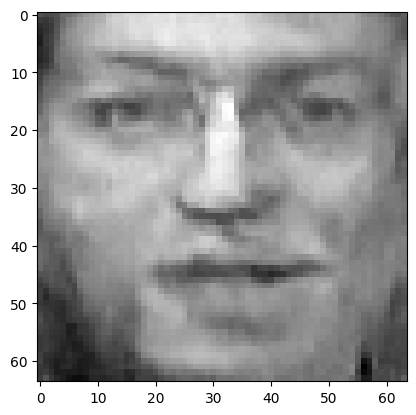

loss(generator):  0.7907202243804932
tensor([[3.3783e-04, 1.1796e-04, 4.5352e-01, 7.1432e-04, 1.5433e-05, 9.5271e-09,
         4.9042e-02, 2.8176e-05, 2.8265e-04, 4.7933e-04, 7.2630e-05, 4.5466e-04,
         3.4628e-02, 8.9503e-03, 9.9163e-07, 2.0629e-05, 4.1506e-03, 2.6967e-07,
         2.8897e-04, 1.1868e-04, 8.1050e-02, 7.2670e-02, 5.0953e-06, 8.7426e-04,
         4.5442e-03, 6.1444e-05, 1.1453e-04, 4.8481e-02, 2.2925e-02, 1.4903e-04,
         1.9941e-02, 1.1360e-06, 5.6632e-03, 1.0598e-03, 2.9133e-03, 4.2040e-05,
         3.6200e-02, 3.8951e-02, 2.0314e-02, 9.0818e-02]],
       grad_fn=<SoftmaxBackward>)


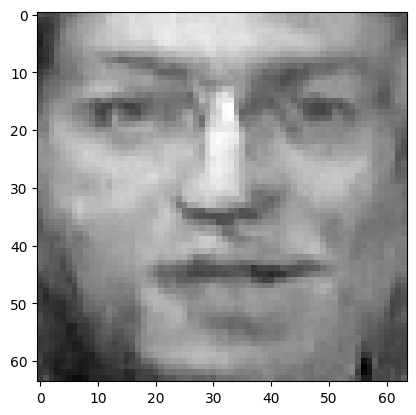

loss(generator):  0.6963240504264832
tensor([[3.5481e-04, 9.6687e-05, 4.9841e-01, 6.7890e-04, 1.2201e-05, 9.0548e-09,
         4.5932e-02, 2.7344e-05, 2.5686e-04, 4.6876e-04, 6.3564e-05, 3.9925e-04,
         3.2434e-02, 8.1565e-03, 7.4786e-07, 1.7928e-05, 4.1392e-03, 2.1554e-07,
         2.5252e-04, 9.9932e-05, 7.2418e-02, 6.3532e-02, 5.0181e-06, 7.1337e-04,
         3.9956e-03, 5.7300e-05, 1.0406e-04, 4.8347e-02, 2.2685e-02, 1.1233e-04,
         1.5539e-02, 9.2601e-07, 4.8385e-03, 8.5263e-04, 2.5327e-03, 3.2894e-05,
         3.6826e-02, 3.7286e-02, 1.6991e-02, 8.1324e-02]],
       grad_fn=<SoftmaxBackward>)


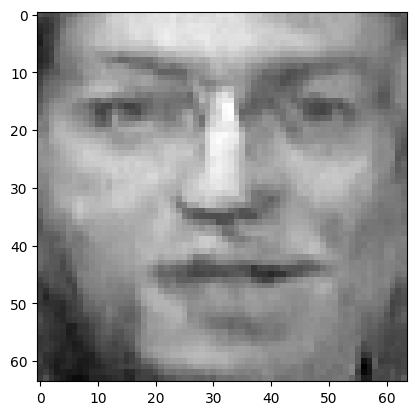

loss(generator):  0.6177440285682678
tensor([[3.6825e-04, 7.9686e-05, 5.3916e-01, 6.4296e-04, 9.8217e-06, 8.5785e-09,
         4.2851e-02, 2.6369e-05, 2.3322e-04, 4.5586e-04, 5.5594e-05, 3.5247e-04,
         3.0305e-02, 7.4214e-03, 5.7313e-07, 1.5668e-05, 4.0887e-03, 1.7456e-07,
         2.2128e-04, 8.4720e-05, 6.4957e-02, 5.5538e-02, 4.9090e-06, 5.8839e-04,
         3.5111e-03, 5.3304e-05, 9.4291e-05, 4.7706e-02, 2.2183e-02, 8.6035e-05,
         1.2262e-02, 7.6152e-07, 4.1502e-03, 6.9157e-04, 2.2098e-03, 2.6121e-05,
         3.6972e-02, 3.5378e-02, 1.4293e-02, 7.2921e-02]],
       grad_fn=<SoftmaxBackward>)


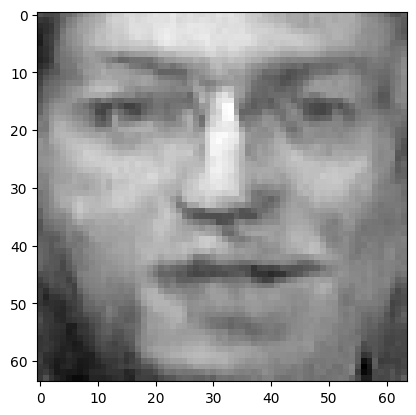

loss(generator):  0.5521944165229797
tensor([[3.8129e-04, 6.6063e-05, 5.7569e-01, 6.0814e-04, 8.0914e-06, 8.2295e-09,
         4.0074e-02, 2.5461e-05, 2.1368e-04, 4.4399e-04, 4.8813e-05, 3.1593e-04,
         2.8337e-02, 6.7638e-03, 4.4743e-07, 1.3881e-05, 4.0131e-03, 1.4596e-07,
         1.9541e-04, 7.2371e-05, 5.8456e-02, 4.8204e-02, 4.8201e-06, 4.9162e-04,
         3.1126e-03, 4.9768e-05, 8.5720e-05, 4.6691e-02, 2.1466e-02, 6.7040e-05,
         9.7617e-03, 6.3660e-07, 3.5740e-03, 5.6235e-04, 1.9421e-03, 2.1065e-05,
         3.6546e-02, 3.3552e-02, 1.2056e-02, 6.6089e-02]],
       grad_fn=<SoftmaxBackward>)


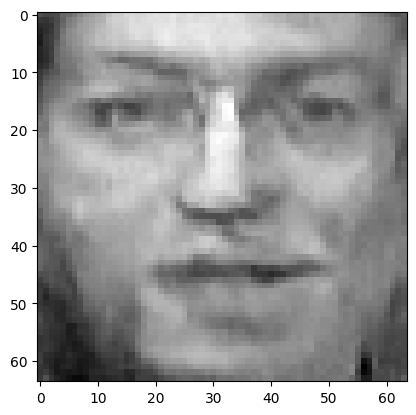

loss(generator):  0.49716293811798096
tensor([[3.9552e-04, 5.5129e-05, 6.0825e-01, 5.7526e-04, 6.8250e-06, 8.0375e-09,
         3.7634e-02, 2.4727e-05, 1.9778e-04, 4.3359e-04, 4.3083e-05, 2.8819e-04,
         2.6544e-02, 6.1935e-03, 3.5584e-07, 1.2472e-05, 3.9201e-03, 1.2651e-07,
         1.7386e-04, 6.2229e-05, 5.2824e-02, 4.1486e-02, 4.7675e-06, 4.1561e-04,
         2.7928e-03, 4.6847e-05, 7.8340e-05, 4.5382e-02, 2.0564e-02, 5.3105e-05,
         7.8359e-03, 5.4260e-07, 3.0897e-03, 4.5825e-04, 1.7217e-03, 1.7238e-05,
         3.5633e-02, 3.1959e-02, 1.0194e-02, 6.0629e-02]],
       grad_fn=<SoftmaxBackward>)


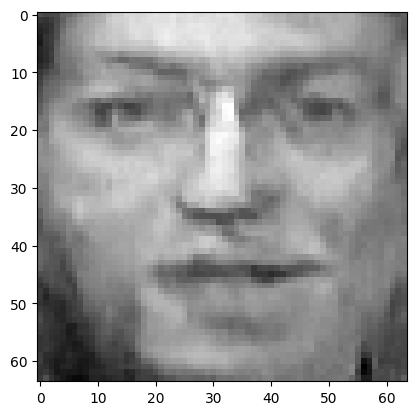

loss(generator):  0.4503604471683502
tensor([[4.0461e-04, 4.6459e-05, 6.3740e-01, 5.4406e-04, 5.7863e-06, 7.7552e-09,
         3.5242e-02, 2.3963e-05, 1.8205e-04, 4.2101e-04, 3.8194e-05, 2.6235e-04,
         2.4807e-02, 5.6771e-03, 2.8682e-07, 1.1210e-05, 3.8083e-03, 1.0919e-07,
         1.5524e-04, 5.4044e-05, 4.8003e-02, 3.6133e-02, 4.6640e-06, 3.5471e-04,
         2.4972e-03, 4.4051e-05, 7.1585e-05, 4.3999e-02, 1.9644e-02, 4.2626e-05,
         6.3803e-03, 4.6386e-07, 2.6860e-03, 3.7941e-04, 1.5320e-03, 1.4277e-05,
         3.4694e-02, 3.0235e-02, 8.7278e-03, 5.5474e-02]],
       grad_fn=<SoftmaxBackward>)


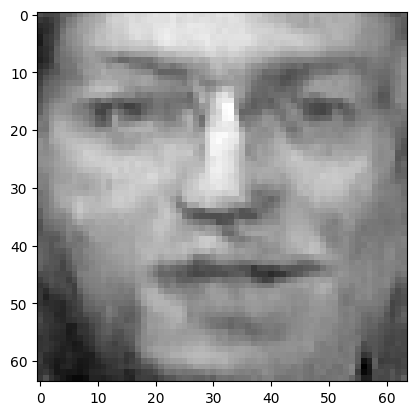

loss(generator):  0.41006481647491455
tensor([[4.1166e-04, 3.9452e-05, 6.6361e-01, 5.1453e-04, 4.9575e-06, 7.4940e-09,
         3.3007e-02, 2.3262e-05, 1.6779e-04, 4.0826e-04, 3.4019e-05, 2.3970e-04,
         2.3191e-02, 5.2144e-03, 2.3410e-07, 1.0131e-05, 3.6898e-03, 9.5047e-08,
         1.3915e-04, 4.7277e-05, 4.3782e-02, 3.1608e-02, 4.5500e-06, 3.0516e-04,
         2.2394e-03, 4.1476e-05, 6.5497e-05, 4.2520e-02, 1.8713e-02, 3.4653e-05,
         5.2459e-03, 3.9967e-07, 2.3487e-03, 3.1697e-04, 1.3698e-03, 1.1959e-05,
         3.3647e-02, 2.8576e-02, 7.5356e-03, 5.0884e-02]],
       grad_fn=<SoftmaxBackward>)


In [12]:
optimize_ddpm_noise_eps(x_i, 10, 0.2, 1, target=2)

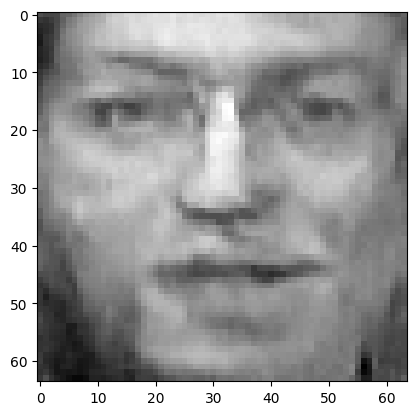

loss(generator):  0.3749833106994629
tensor([[4.1710e-04, 3.3695e-05, 6.8730e-01, 4.8705e-04, 4.2918e-06, 7.2716e-09,
         3.0950e-02, 2.2645e-05, 1.5509e-04, 3.9590e-04, 3.0442e-05, 2.1986e-04,
         2.1692e-02, 4.7956e-03, 1.9331e-07, 9.2137e-06, 3.5681e-03, 8.3594e-08,
         1.2521e-04, 4.1651e-05, 4.0061e-02, 2.7711e-02, 4.4369e-06, 2.6447e-04,
         2.0152e-03, 3.9109e-05, 6.0003e-05, 4.0978e-02, 1.7785e-02, 2.8489e-05,
         4.3435e-03, 3.4691e-07, 2.0645e-03, 2.6651e-04, 1.2310e-03, 1.0122e-05,
         3.2491e-02, 2.7004e-02, 6.5523e-03, 4.6842e-02]],
       grad_fn=<SoftmaxBackward>)


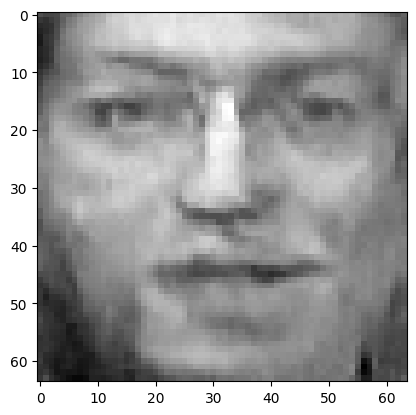

loss(generator):  0.3446829319000244
tensor([[4.2077e-04, 2.8966e-05, 7.0844e-01, 4.6171e-04, 3.7546e-06, 7.0649e-09,
         2.9010e-02, 2.2123e-05, 1.4383e-04, 3.8516e-04, 2.7390e-05, 2.0284e-04,
         2.0306e-02, 4.4161e-03, 1.6180e-07, 8.4279e-06, 3.4496e-03, 7.4274e-08,
         1.1333e-04, 3.6966e-05, 3.6861e-02, 2.4419e-02, 4.3353e-06, 2.3111e-04,
         1.8255e-03, 3.7018e-05, 5.5168e-05, 3.9448e-02, 1.6886e-02, 2.3750e-05,
         3.6290e-03, 3.0351e-07, 1.8269e-03, 2.2591e-04, 1.1142e-03, 8.6609e-06,
         3.1280e-02, 2.5565e-02, 5.7419e-03, 4.3335e-02]],
       grad_fn=<SoftmaxBackward>)


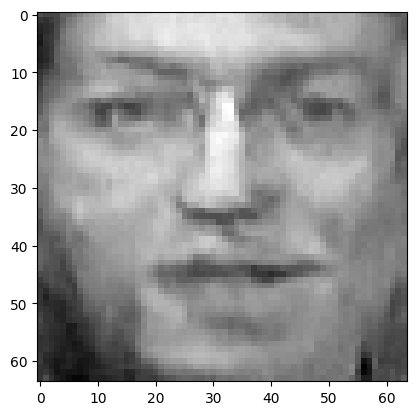

loss(generator):  0.3184470534324646
tensor([[4.2184e-04, 2.5111e-05, 7.2728e-01, 4.3850e-04, 3.3045e-06, 6.8332e-09,
         2.7211e-02, 2.1622e-05, 1.3350e-04, 3.7457e-04, 2.4773e-05, 1.8723e-04,
         1.9043e-02, 4.0727e-03, 1.3694e-07, 7.7423e-06, 3.3318e-03, 6.6124e-08,
         1.0306e-04, 3.3095e-05, 3.4086e-02, 2.1719e-02, 4.2182e-06, 2.0371e-04,
         1.6568e-03, 3.4999e-05, 5.0835e-05, 3.7970e-02, 1.6069e-02, 2.0051e-05,
         3.0638e-03, 2.6662e-07, 1.6292e-03, 1.9367e-04, 1.0136e-03, 7.4874e-06,
         3.0117e-02, 2.4190e-02, 5.0815e-03, 4.0179e-02]],
       grad_fn=<SoftmaxBackward>)


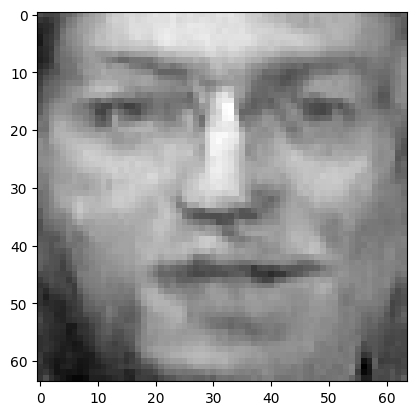

loss(generator):  0.2954358160495758
tensor([[4.2222e-04, 2.1930e-05, 7.4421e-01, 4.1702e-04, 2.9350e-06, 6.6282e-09,
         2.5593e-02, 2.1175e-05, 1.2437e-04, 3.6468e-04, 2.2523e-05, 1.7369e-04,
         1.7891e-02, 3.7668e-03, 1.1701e-07, 7.1582e-06, 3.2178e-03, 5.9401e-08,
         9.4241e-05, 2.9814e-05, 3.1631e-02, 1.9403e-02, 4.1056e-06, 1.8089e-04,
         1.5099e-03, 3.3158e-05, 4.6978e-05, 3.6523e-02, 1.5284e-02, 1.7095e-05,
         2.6073e-03, 2.3605e-07, 1.4604e-03, 1.6718e-04, 9.2671e-04, 6.5312e-06,
         2.8951e-02, 2.2918e-02, 4.5217e-03, 3.7430e-02]],
       grad_fn=<SoftmaxBackward>)


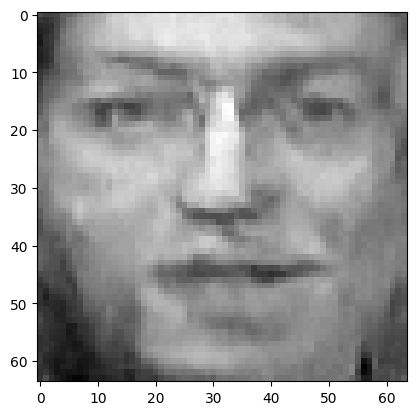

loss(generator):  0.27503424882888794
tensor([[4.2011e-04, 1.9281e-05, 7.5955e-01, 3.9669e-04, 2.6179e-06, 6.4095e-09,
         2.4094e-02, 2.0733e-05, 1.1608e-04, 3.5538e-04, 2.0601e-05, 1.6115e-04,
         1.6802e-02, 3.4850e-03, 1.0093e-07, 6.6491e-06, 3.1029e-03, 5.3462e-08,
         8.6624e-05, 2.7094e-05, 2.9443e-02, 1.7454e-02, 3.9838e-06, 1.6178e-04,
         1.3771e-03, 3.1341e-05, 4.3496e-05, 3.5138e-02, 1.4570e-02, 1.4736e-05,
         2.2361e-03, 2.0942e-07, 1.3157e-03, 1.4561e-04, 8.5081e-04, 5.7469e-06,
         2.7807e-02, 2.1684e-02, 4.0497e-03, 3.5002e-02]],
       grad_fn=<SoftmaxBackward>)


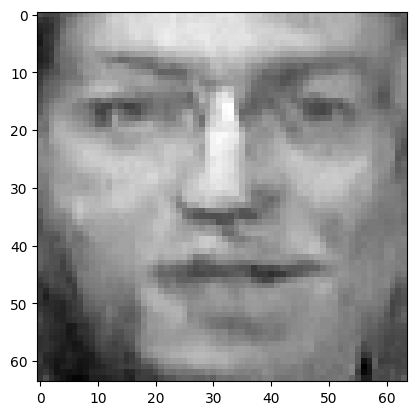

loss(generator):  0.2567468285560608
tensor([[4.1617e-04, 1.7048e-05, 7.7356e-01, 3.7767e-04, 2.3433e-06, 6.1830e-09,
         2.2697e-02, 2.0286e-05, 1.0844e-04, 3.4644e-04, 1.8928e-05, 1.4954e-04,
         1.5783e-02, 3.2276e-03, 8.7699e-08, 6.1960e-06, 2.9893e-03, 4.8151e-08,
         7.9925e-05, 2.4780e-05, 2.7471e-02, 1.5792e-02, 3.8564e-06, 1.4544e-04,
         1.2570e-03, 2.9604e-05, 4.0356e-05, 3.3838e-02, 1.3908e-02, 1.2802e-05,
         1.9308e-03, 1.8627e-07, 1.1897e-03, 1.2775e-04, 7.8294e-04, 5.0905e-06,
         2.6706e-02, 2.0489e-02, 3.6455e-03, 3.2796e-02]],
       grad_fn=<SoftmaxBackward>)


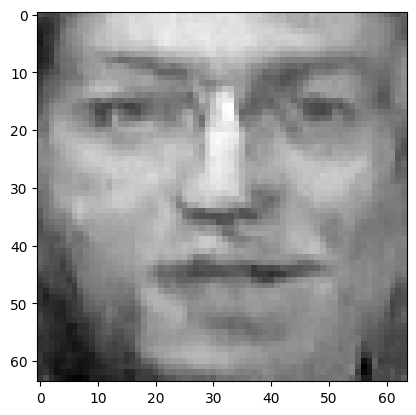

loss(generator):  0.24054104089736938
tensor([[4.1216e-04, 1.5172e-05, 7.8620e-01, 3.6038e-04, 2.1126e-06, 5.9830e-09,
         2.1419e-02, 1.9918e-05, 1.0171e-04, 3.3850e-04, 1.7488e-05, 1.3943e-04,
         1.4866e-02, 2.9989e-03, 7.6890e-08, 5.8036e-06, 2.8826e-03, 4.3702e-08,
         7.4055e-05, 2.2801e-05, 2.5714e-02, 1.4349e-02, 3.7360e-06, 1.3152e-04,
         1.1520e-03, 2.8035e-05, 3.7579e-05, 3.2621e-02, 1.3284e-02, 1.1221e-05,
         1.6777e-03, 1.6686e-07, 1.0816e-03, 1.1278e-04, 7.2298e-04, 4.5397e-06,
         2.5639e-02, 1.9408e-02, 3.3025e-03, 3.0841e-02]],
       grad_fn=<SoftmaxBackward>)


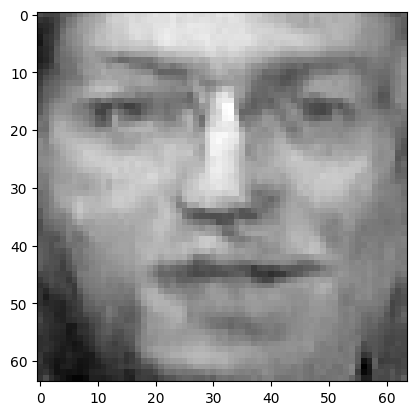

loss(generator):  0.22629648447036743
tensor([[4.0725e-04, 1.3609e-05, 7.9748e-01, 3.4495e-04, 1.9129e-06, 5.7815e-09,
         2.0256e-02, 1.9561e-05, 9.5544e-05, 3.3068e-04, 1.6239e-05, 1.3034e-04,
         1.4034e-02, 2.7991e-03, 6.7960e-08, 5.4457e-06, 2.7824e-03, 3.9737e-08,
         6.8895e-05, 2.1097e-05, 2.4167e-02, 1.3143e-02, 3.6154e-06, 1.1964e-04,
         1.0594e-03, 2.6628e-05, 3.5140e-05, 3.1520e-02, 1.2717e-02, 9.9112e-06,
         1.4718e-03, 1.5032e-07, 9.8844e-04, 1.0055e-04, 6.6967e-04, 4.0730e-06,
         2.4693e-02, 1.8409e-02, 3.0137e-03, 2.9038e-02]],
       grad_fn=<SoftmaxBackward>)


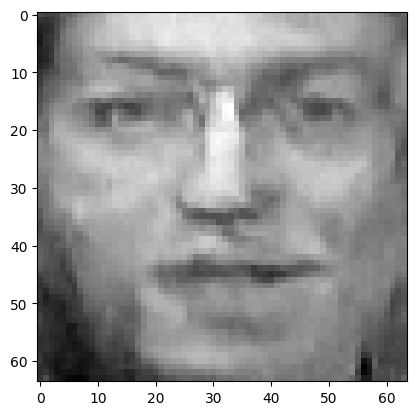

loss(generator):  0.21343855559825897
tensor([[4.0269e-04, 1.2256e-05, 8.0780e-01, 3.3059e-04, 1.7423e-06, 5.6064e-09,
         1.9194e-02, 1.9238e-05, 9.0059e-05, 3.2347e-04, 1.5126e-05, 1.2236e-04,
         1.3273e-02, 2.6193e-03, 6.0421e-08, 5.1295e-06, 2.6869e-03, 3.6398e-08,
         6.4302e-05, 1.9588e-05, 2.2769e-02, 1.2057e-02, 3.5054e-06, 1.0928e-04,
         9.7796e-04, 2.5355e-05, 3.2945e-05, 3.0464e-02, 1.2177e-02, 8.8059e-06,
         1.2972e-03, 1.3613e-07, 9.0616e-04, 8.9959e-05, 6.2237e-04, 3.6721e-06,
         2.3767e-02, 1.7504e-02, 2.7584e-03, 2.7444e-02]],
       grad_fn=<SoftmaxBackward>)


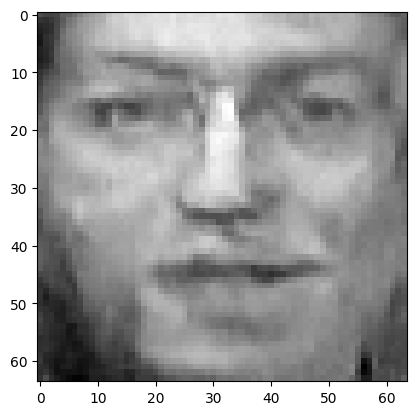

loss(generator):  0.20183339715003967
tensor([[3.9785e-04, 1.1088e-05, 8.1723e-01, 3.1725e-04, 1.5944e-06, 5.4398e-09,
         1.8219e-02, 1.8928e-05, 8.5070e-05, 3.1663e-04, 1.4133e-05, 1.1515e-04,
         1.2576e-02, 2.4569e-03, 5.4031e-08, 4.8463e-06, 2.5959e-03, 3.3466e-08,
         6.0197e-05, 1.8262e-05, 2.1512e-02, 1.1102e-02, 3.3993e-06, 1.0027e-04,
         9.0521e-04, 2.4176e-05, 3.0956e-05, 2.9464e-02, 1.1673e-02, 7.8726e-06,
         1.1500e-03, 1.2377e-07, 8.3391e-04, 8.0913e-05, 5.8025e-04, 3.3286e-06,
         2.2886e-02, 1.6663e-02, 2.5352e-03, 2.6005e-02]],
       grad_fn=<SoftmaxBackward>)


In [13]:
optimize_ddpm_noise_eps(x_i, 10, 0.2, 1, target=2)

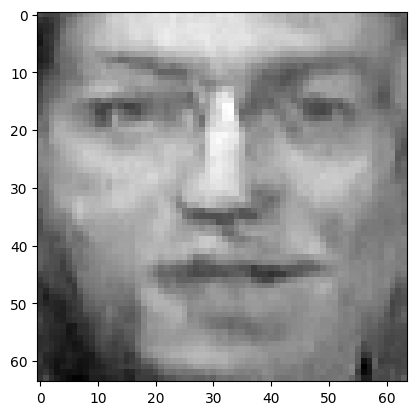

loss(generator):  0.19129306077957153
tensor([[3.9361e-04, 1.0067e-05, 8.2589e-01, 3.0480e-04, 1.4691e-06, 5.3024e-09,
         1.7335e-02, 1.8656e-05, 8.0665e-05, 3.1042e-04, 1.3243e-05, 1.0896e-04,
         1.1937e-02, 2.3121e-03, 4.8589e-08, 4.5967e-06, 2.5102e-03, 3.1023e-08,
         5.6537e-05, 1.7069e-05, 2.0372e-02, 1.0230e-02, 3.3058e-06, 9.2379e-05,
         8.4175e-04, 2.3142e-05, 2.9177e-05, 2.8509e-02, 1.1181e-02, 7.0756e-06,
         1.0244e-03, 1.1324e-07, 7.6943e-04, 7.2996e-05, 5.4278e-04, 3.0318e-06,
         2.2022e-02, 1.5902e-02, 2.3364e-03, 2.4732e-02]],
       grad_fn=<SoftmaxBackward>)


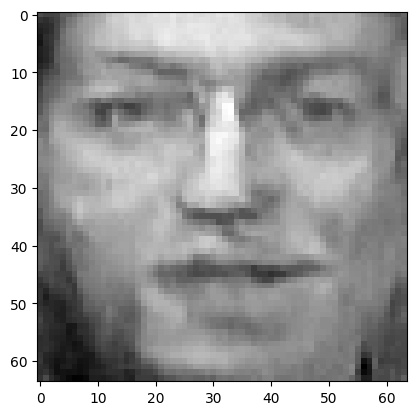

loss(generator):  0.18166135251522064
tensor([[3.8944e-04, 9.1688e-06, 8.3388e-01, 2.9317e-04, 1.3592e-06, 5.1769e-09,
         1.6523e-02, 1.8405e-05, 7.6680e-05, 3.0475e-04, 1.2439e-05, 1.0336e-04,
         1.1350e-02, 2.1789e-03, 4.3883e-08, 4.3736e-06, 2.4298e-03, 2.8876e-08,
         5.3229e-05, 1.6003e-05, 1.9328e-02, 9.4490e-03, 3.2180e-06, 8.5427e-05,
         7.8459e-04, 2.2176e-05, 2.7547e-05, 2.7602e-02, 1.0719e-02, 6.3887e-06,
         9.1622e-04, 1.0395e-07, 7.1201e-04, 6.6058e-05, 5.0913e-04, 2.7728e-06,
         2.1189e-02, 1.5193e-02, 2.1595e-03, 2.3576e-02]],
       grad_fn=<SoftmaxBackward>)


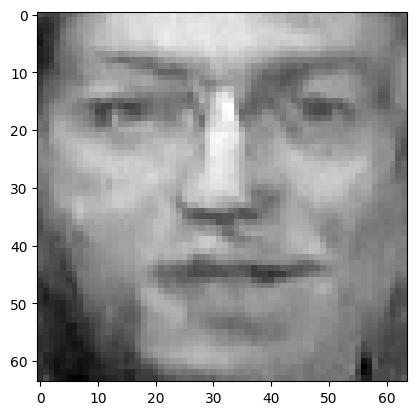

loss(generator):  0.17304986715316772
tensor([[3.8553e-04, 8.4016e-06, 8.4110e-01, 2.8247e-04, 1.2645e-06, 5.0655e-09,
         1.5795e-02, 1.8192e-05, 7.3052e-05, 2.9952e-04, 1.1729e-05, 9.8423e-05,
         1.0811e-02, 2.0614e-03, 3.9851e-08, 4.1747e-06, 2.3563e-03, 2.6995e-08,
         5.0305e-05, 1.5050e-05, 1.8387e-02, 8.7645e-03, 3.1379e-06, 7.9318e-05,
         7.3444e-04, 2.1320e-05, 2.6113e-05, 2.6763e-02, 1.0290e-02, 5.8001e-06,
         8.2445e-04, 9.6025e-08, 6.6147e-04, 6.0132e-05, 4.7937e-04, 2.5476e-06,
         2.0425e-02, 1.4555e-02, 2.0030e-03, 2.2546e-02]],
       grad_fn=<SoftmaxBackward>)


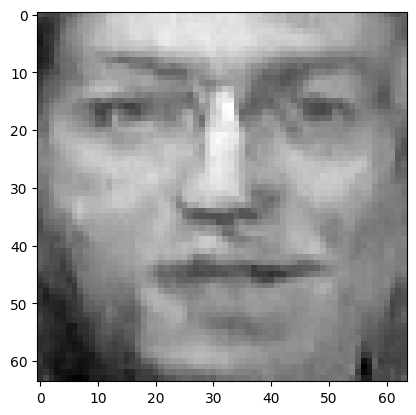

loss(generator):  0.16557924449443817
tensor([[3.7967e-04, 7.7856e-06, 8.4740e-01, 2.7277e-04, 1.1767e-06, 4.9095e-09,
         1.5109e-02, 1.7920e-05, 6.9331e-05, 2.9328e-04, 1.1112e-05, 9.3672e-05,
         1.0314e-02, 1.9642e-03, 3.6377e-08, 3.9716e-06, 2.2913e-03, 2.4973e-08,
         4.7722e-05, 1.4184e-05, 1.7563e-02, 8.2452e-03, 3.0481e-06, 7.3838e-05,
         6.8936e-04, 2.0588e-05, 2.4899e-05, 2.6066e-02, 9.9112e-03, 5.2899e-06,
         7.5156e-04, 8.9221e-08, 6.1741e-04, 5.5515e-05, 4.5181e-04, 2.3485e-06,
         1.9872e-02, 1.3960e-02, 1.8722e-03, 2.1520e-02]],
       grad_fn=<SoftmaxBackward>)


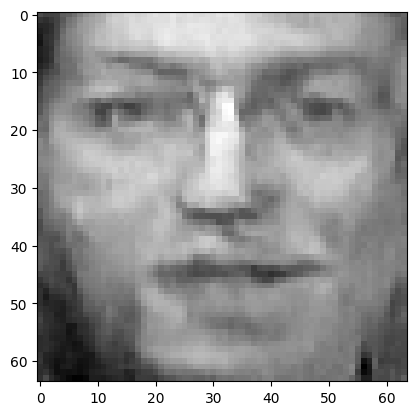

loss(generator):  0.1586514115333557
tensor([[3.7405e-04, 7.2316e-06, 8.5329e-01, 2.6364e-04, 1.0984e-06, 4.7672e-09,
         1.4472e-02, 1.7666e-05, 6.5940e-05, 2.8745e-04, 1.0548e-05, 8.9331e-05,
         9.8515e-03, 1.8739e-03, 3.3319e-08, 3.7878e-06, 2.2287e-03, 2.3197e-08,
         4.5360e-05, 1.3398e-05, 1.6799e-02, 7.7653e-03, 2.9636e-06, 6.8914e-05,
         6.4840e-04, 1.9897e-05, 2.3776e-05, 2.5394e-02, 9.5527e-03, 4.8424e-06,
         6.8695e-04, 8.3116e-08, 5.7755e-04, 5.1363e-05, 4.2669e-04, 2.1718e-06,
         1.9327e-02, 1.3408e-02, 1.7531e-03, 2.0587e-02]],
       grad_fn=<SoftmaxBackward>)


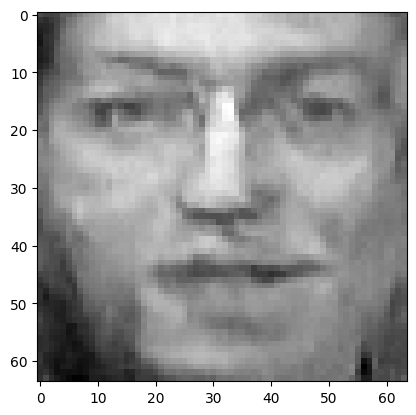

loss(generator):  0.15219414234161377
tensor([[3.6871e-04, 6.7297e-06, 8.5882e-01, 2.5504e-04, 1.0284e-06, 4.6388e-09,
         1.3879e-02, 1.7430e-05, 6.2851e-05, 2.8205e-04, 1.0029e-05, 8.5362e-05,
         9.4213e-03, 1.7896e-03, 3.0611e-08, 3.6215e-06, 2.1684e-03, 2.1636e-08,
         4.3191e-05, 1.2684e-05, 1.6088e-02, 7.3178e-03, 2.8848e-06, 6.4467e-05,
         6.1102e-04, 1.9245e-05, 2.2734e-05, 2.4746e-02, 9.2120e-03, 4.4471e-06,
         6.2918e-04, 7.7616e-08, 5.4124e-04, 4.7595e-05, 4.0367e-04, 2.0139e-06,
         1.8786e-02, 1.2893e-02, 1.6439e-03, 1.9736e-02]],
       grad_fn=<SoftmaxBackward>)


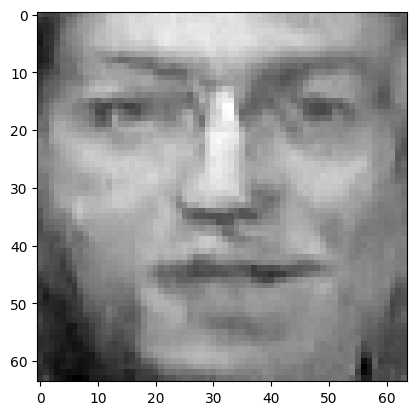

loss(generator):  0.14619188010692596
tensor([[3.6423e-04, 6.2717e-06, 8.6399e-01, 2.4693e-04, 9.6649e-07, 4.5324e-09,
         1.3335e-02, 1.7230e-05, 6.0095e-05, 2.7730e-04, 9.5499e-06, 8.1785e-05,
         9.0273e-03, 1.7105e-03, 2.8206e-08, 3.4741e-06, 2.1113e-03, 2.0309e-08,
         4.1188e-05, 1.2030e-05, 1.5419e-02, 6.8942e-03, 2.8146e-06, 6.0455e-05,
         5.7738e-04, 1.8624e-05, 2.1766e-05, 2.4112e-02, 8.8914e-03, 4.0985e-06,
         5.7708e-04, 7.2684e-08, 5.0844e-04, 4.4135e-05, 3.8288e-04, 1.8731e-06,
         1.8242e-02, 1.2425e-02, 1.5434e-03, 1.8976e-02]],
       grad_fn=<SoftmaxBackward>)


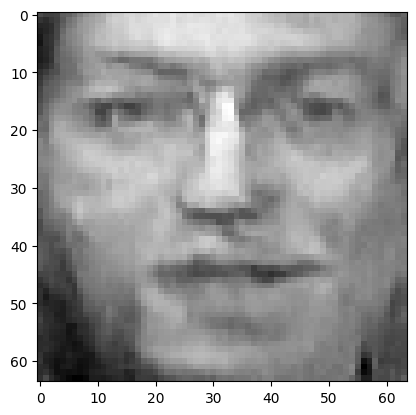

loss(generator):  0.14061395823955536
tensor([[3.6010e-04, 5.8579e-06, 8.6882e-01, 2.3931e-04, 9.1113e-07, 4.4371e-09,
         1.2832e-02, 1.7045e-05, 5.7568e-05, 2.7282e-04, 9.1069e-06, 7.8535e-05,
         8.6616e-03, 1.6376e-03, 2.6066e-08, 3.3385e-06, 2.0567e-03, 1.9138e-08,
         3.9342e-05, 1.1430e-05, 1.4800e-02, 6.5025e-03, 2.7491e-06, 5.6824e-05,
         5.4673e-04, 1.8051e-05, 2.0867e-05, 2.3502e-02, 8.5849e-03, 3.7889e-06,
         5.3083e-04, 6.8255e-08, 4.7862e-04, 4.1017e-05, 3.6391e-04, 1.7469e-06,
         1.7716e-02, 1.1992e-02, 1.4517e-03, 1.8278e-02]],
       grad_fn=<SoftmaxBackward>)


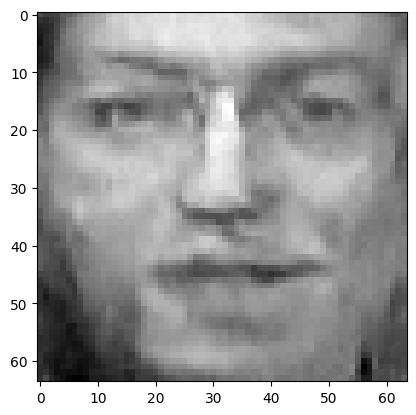

loss(generator):  0.13537973165512085
tensor([[3.5619e-04, 5.4793e-06, 8.7338e-01, 2.3213e-04, 8.6066e-07, 4.3495e-09,
         1.2361e-02, 1.6872e-05, 5.5227e-05, 2.6853e-04, 8.6942e-06, 7.5514e-05,
         8.3171e-03, 1.5693e-03, 2.4144e-08, 3.2117e-06, 2.0044e-03, 1.8088e-08,
         3.7621e-05, 1.0878e-05, 1.4221e-02, 6.1381e-03, 2.6880e-06, 5.3503e-05,
         5.1833e-04, 1.7509e-05, 2.0020e-05, 2.2910e-02, 8.2937e-03, 3.5104e-06,
         4.8908e-04, 6.4203e-08, 4.5127e-04, 3.8175e-05, 3.4649e-04, 1.6322e-06,
         1.7209e-02, 1.1587e-02, 1.3674e-03, 1.7624e-02]],
       grad_fn=<SoftmaxBackward>)


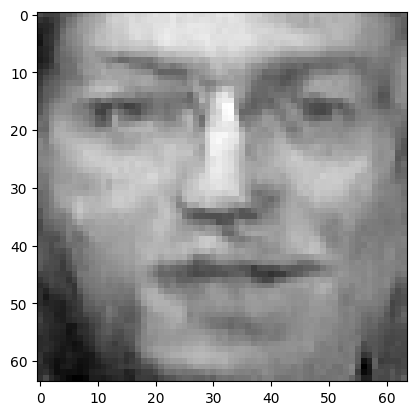

loss(generator):  0.13047409057617188
tensor([[3.5248e-04, 5.1338e-06, 8.7768e-01, 2.2534e-04, 8.1484e-07, 4.2685e-09,
         1.1918e-02, 1.6710e-05, 5.3061e-05, 2.6456e-04, 8.3112e-06, 7.2702e-05,
         7.9943e-03, 1.5049e-03, 2.2420e-08, 3.0952e-06, 1.9541e-03, 1.7140e-08,
         3.6026e-05, 1.0373e-05, 1.3682e-02, 5.8007e-03, 2.6303e-06, 5.0475e-05,
         4.9205e-04, 1.6990e-05, 1.9225e-05, 2.2339e-02, 8.0189e-03, 3.2614e-06,
         4.5147e-04, 6.0487e-08, 4.2624e-04, 3.5590e-05, 3.3045e-04, 1.5288e-06,
         1.6716e-02, 1.1205e-02, 1.2900e-03, 1.7020e-02]],
       grad_fn=<SoftmaxBackward>)


In [14]:
optimize_ddpm_noise_eps(x_i, 10, 0.2, 1, target=2)

In [16]:
torch.save(x_i, 'attack2.pt')

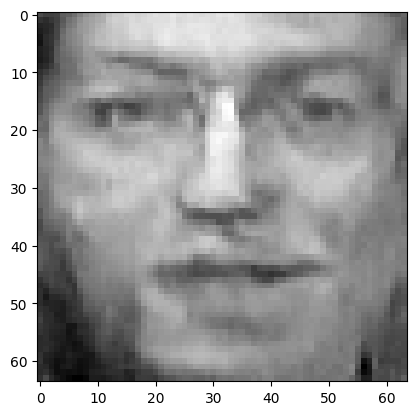

loss(generator):  0.12588192522525787
tensor([[3.4927e-04, 4.8191e-06, 8.8172e-01, 2.1889e-04, 7.7376e-07, 4.1993e-09,
         1.1504e-02, 1.6574e-05, 5.1088e-05, 2.6106e-04, 7.9577e-06, 7.0155e-05,
         7.6934e-03, 1.4445e-03, 2.0872e-08, 2.9907e-06, 1.9057e-03, 1.6311e-08,
         3.4558e-05, 9.9091e-06, 1.3175e-02, 5.4839e-03, 2.5770e-06, 4.7720e-05,
         4.6810e-04, 1.6497e-05, 1.8489e-05, 2.1786e-02, 7.7576e-03, 3.0398e-06,
         4.1747e-04, 5.7099e-08, 4.0330e-04, 3.3220e-05, 3.1578e-04, 1.4358e-06,
         1.6227e-02, 1.0854e-02, 1.2183e-03, 1.6477e-02]],
       grad_fn=<SoftmaxBackward>)


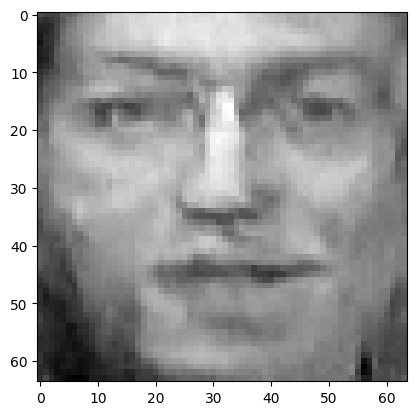

loss(generator):  0.12173381447792053
tensor([[3.4607e-04, 4.5464e-06, 8.8538e-01, 2.1294e-04, 7.3491e-07, 4.1206e-09,
         1.1115e-02, 1.6431e-05, 4.9160e-05, 2.5735e-04, 7.6368e-06, 6.7776e-05,
         7.4176e-03, 1.3915e-03, 1.9467e-08, 2.8860e-06, 1.8614e-03, 1.5485e-08,
         3.3205e-05, 9.4727e-06, 1.2705e-02, 5.2129e-03, 2.5233e-06, 4.5178e-05,
         4.4653e-04, 1.6069e-05, 1.7842e-05, 2.1304e-02, 7.5162e-03, 2.8383e-06,
         3.8818e-04, 5.4053e-08, 3.8237e-04, 3.1165e-05, 3.0197e-04, 1.3503e-06,
         1.5816e-02, 1.0534e-02, 1.1549e-03, 1.5943e-02]],
       grad_fn=<SoftmaxBackward>)


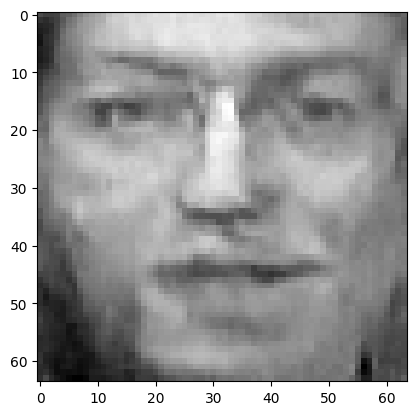

loss(generator):  0.11781853437423706
tensor([[3.4290e-04, 4.2953e-06, 8.8886e-01, 2.0729e-04, 6.9913e-07, 4.0454e-09,
         1.0748e-02, 1.6293e-05, 4.7352e-05, 2.5381e-04, 7.3359e-06, 6.5525e-05,
         7.1579e-03, 1.3411e-03, 1.8193e-08, 2.7885e-06, 1.8185e-03, 1.4725e-08,
         3.1939e-05, 9.0704e-06, 1.2265e-02, 4.9612e-03, 2.4713e-06, 4.2845e-05,
         4.2634e-04, 1.5653e-05, 1.7228e-05, 2.0837e-02, 7.2875e-03, 2.6563e-06,
         3.6161e-04, 5.1223e-08, 3.6310e-04, 2.9286e-05, 2.8914e-04, 1.2725e-06,
         1.5417e-02, 1.0230e-02, 1.0963e-03, 1.5444e-02]],
       grad_fn=<SoftmaxBackward>)


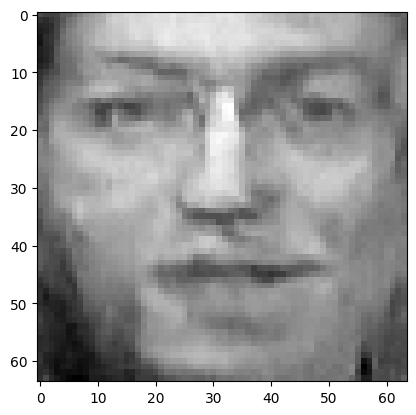

loss(generator):  0.11410197615623474
tensor([[3.3989e-04, 4.0622e-06, 8.9217e-01, 2.0192e-04, 6.6605e-07, 3.9747e-09,
         1.0400e-02, 1.6165e-05, 4.5651e-05, 2.5048e-04, 7.0526e-06, 6.3411e-05,
         6.9122e-03, 1.2933e-03, 1.7032e-08, 2.6971e-06, 1.7770e-03, 1.4028e-08,
         3.0754e-05, 8.6950e-06, 1.1849e-02, 4.7242e-03, 2.4219e-06, 4.0694e-05,
         4.0743e-04, 1.5255e-05, 1.6646e-05, 2.0385e-02, 7.0682e-03, 2.4898e-06,
         3.3725e-04, 4.8596e-08, 3.4514e-04, 2.7548e-05, 2.7715e-04, 1.2012e-06,
         1.5027e-02, 9.9372e-03, 1.0416e-03, 1.4973e-02]],
       grad_fn=<SoftmaxBackward>)


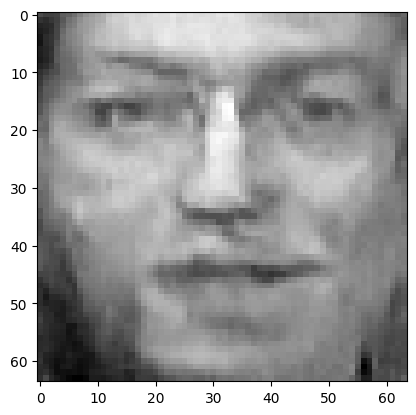

loss(generator):  0.11059068888425827
tensor([[3.3696e-04, 3.8468e-06, 8.9531e-01, 1.9680e-04, 6.3554e-07, 3.9077e-09,
         1.0072e-02, 1.6043e-05, 4.4057e-05, 2.4732e-04, 6.7869e-06, 6.1419e-05,
         6.6807e-03, 1.2481e-03, 1.5975e-08, 2.6121e-06, 1.7371e-03, 1.3387e-08,
         2.9642e-05, 8.3469e-06, 1.1458e-02, 4.5030e-03, 2.3746e-06, 3.8713e-05,
         3.8975e-04, 1.4873e-05, 1.6094e-05, 1.9950e-02, 6.8600e-03, 2.3385e-06,
         3.1504e-04, 4.6161e-08, 3.2853e-04, 2.5951e-05, 2.6600e-04, 1.1359e-06,
         1.4649e-02, 9.6585e-03, 9.9092e-04, 1.4533e-02]],
       grad_fn=<SoftmaxBackward>)


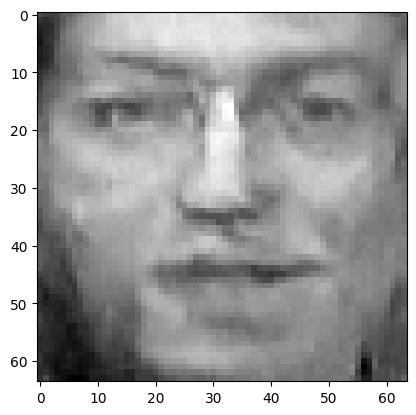

loss(generator):  0.10727500915527344
tensor([[3.3411e-04, 3.6483e-06, 8.9828e-01, 1.9191e-04, 6.0708e-07, 3.8415e-09,
         9.7599e-03, 1.5924e-05, 4.2535e-05, 2.4424e-04, 6.5360e-06, 5.9516e-05,
         6.4625e-03, 1.2053e-03, 1.5007e-08, 2.5313e-06, 1.6986e-03, 1.2784e-08,
         2.8594e-05, 8.0223e-06, 1.1091e-02, 4.2984e-03, 2.3281e-06, 3.6878e-05,
         3.7309e-04, 1.4503e-05, 1.5568e-05, 1.9530e-02, 6.6633e-03, 2.2002e-06,
         2.9484e-04, 4.3884e-08, 3.1316e-04, 2.4490e-05, 2.5557e-04, 1.0759e-06,
         1.4290e-02, 9.3923e-03, 9.4407e-04, 1.4115e-02]],
       grad_fn=<SoftmaxBackward>)


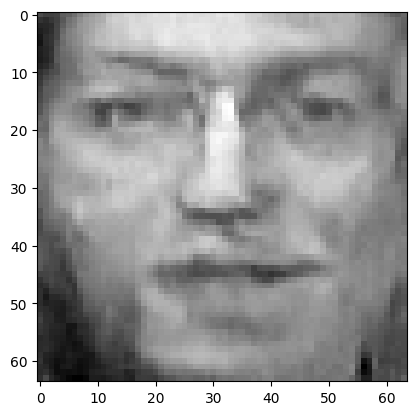

loss(generator):  0.10417872667312622
tensor([[3.3184e-04, 3.4667e-06, 9.0106e-01, 1.8734e-04, 5.8242e-07, 3.7897e-09,
         9.4742e-03, 1.5823e-05, 4.1148e-05, 2.4138e-04, 6.3031e-06, 5.7916e-05,
         6.2571e-03, 1.1671e-03, 1.4138e-08, 2.4566e-06, 1.6625e-03, 1.2270e-08,
         2.7636e-05, 7.7150e-06, 1.0751e-02, 4.1030e-03, 2.2887e-06, 3.5191e-05,
         3.5829e-04, 1.4205e-05, 1.5089e-05, 1.9131e-02, 6.4633e-03, 2.0736e-06,
         2.7669e-04, 4.1913e-08, 2.9869e-04, 2.3139e-05, 2.4599e-04, 1.0210e-06,
         1.3942e-02, 9.1490e-03, 9.0038e-04, 1.3738e-02]],
       grad_fn=<SoftmaxBackward>)


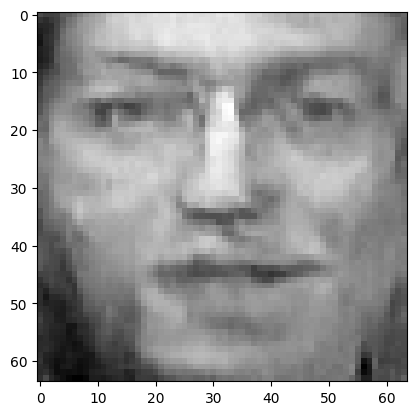

loss(generator):  0.10123778134584427
tensor([[3.2962e-04, 3.2977e-06, 9.0372e-01, 1.8296e-04, 5.5945e-07, 3.7408e-09,
         9.2035e-03, 1.5726e-05, 3.9838e-05, 2.3863e-04, 6.0827e-06, 5.6404e-05,
         6.0625e-03, 1.1309e-03, 1.3336e-08, 2.3860e-06, 1.6277e-03, 1.1791e-08,
         2.6731e-05, 7.4264e-06, 1.0430e-02, 3.9198e-03, 2.2507e-06, 3.3619e-05,
         3.4439e-04, 1.3919e-05, 1.4634e-05, 1.8745e-02, 6.2718e-03, 1.9571e-06,
         2.6005e-04, 4.0075e-08, 2.8519e-04, 2.1890e-05, 2.3698e-04, 9.7021e-07,
         1.3606e-02, 8.9170e-03, 8.5954e-04, 1.3383e-02]],
       grad_fn=<SoftmaxBackward>)


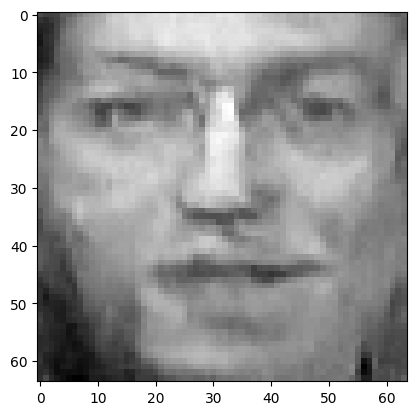

loss(generator):  0.09844093024730682
tensor([[3.2752e-04, 3.1401e-06, 9.0625e-01, 1.7875e-04, 5.3811e-07, 3.6950e-09,
         8.9475e-03, 1.5634e-05, 3.8603e-05, 2.3600e-04, 5.8740e-06, 5.4971e-05,
         5.8784e-03, 1.0965e-03, 1.2597e-08, 2.3197e-06, 1.5943e-03, 1.1347e-08,
         2.5873e-05, 7.1557e-06, 1.0124e-02, 3.7478e-03, 2.2143e-06, 3.2155e-05,
         3.3131e-04, 1.3643e-05, 1.4199e-05, 1.8371e-02, 6.0889e-03, 1.8501e-06,
         2.4473e-04, 3.8357e-08, 2.7263e-04, 2.0731e-05, 2.2854e-04, 9.2323e-07,
         1.3279e-02, 8.6951e-03, 8.2131e-04, 1.3047e-02]],
       grad_fn=<SoftmaxBackward>)


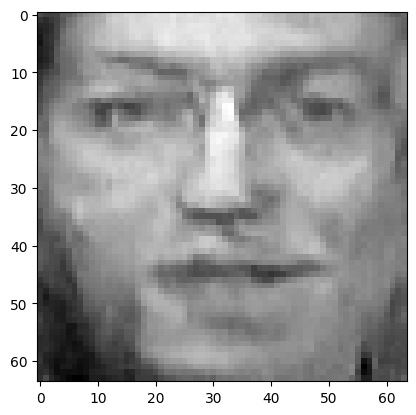

loss(generator):  0.09577663242816925
tensor([[3.2553e-04, 2.9931e-06, 9.0867e-01, 1.7472e-04, 5.1820e-07, 3.6523e-09,
         8.7047e-03, 1.5547e-05, 3.7441e-05, 2.3352e-04, 5.6763e-06, 5.3606e-05,
         5.7041e-03, 1.0636e-03, 1.1915e-08, 2.2577e-06, 1.5618e-03, 1.0935e-08,
         2.5060e-05, 6.9027e-06, 9.8333e-03, 3.5859e-03, 2.1791e-06, 3.0790e-05,
         3.1894e-04, 1.3371e-05, 1.3783e-05, 1.8008e-02, 5.9151e-03, 1.7518e-06,
         2.3060e-04, 3.6743e-08, 2.6094e-04, 1.9654e-05, 2.2061e-04, 8.7978e-07,
         1.2960e-02, 8.4828e-03, 7.8546e-04, 1.2731e-02]],
       grad_fn=<SoftmaxBackward>)


In [17]:
optimize_ddpm_noise_eps(x_i, 10, 0.2, 1, target=2)

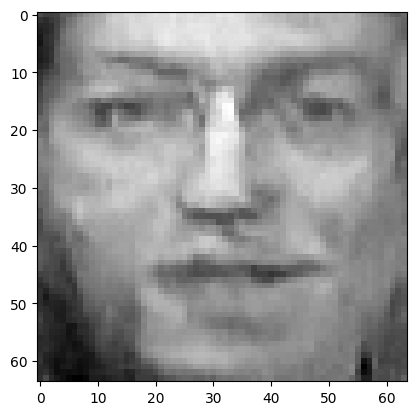

loss(generator):  0.09323956072330475
tensor([[3.2349e-04, 2.8560e-06, 9.1098e-01, 1.7085e-04, 4.9941e-07, 3.6098e-09,
         8.4727e-03, 1.5460e-05, 3.6330e-05, 2.3109e-04, 5.4891e-06, 5.2286e-05,
         5.5384e-03, 1.0321e-03, 1.1283e-08, 2.1987e-06, 1.5305e-03, 1.0543e-08,
         2.4287e-05, 6.6653e-06, 9.5571e-03, 3.4350e-03, 2.1444e-06, 2.9513e-05,
         3.0723e-04, 1.3106e-05, 1.3386e-05, 1.7656e-02, 5.7502e-03, 1.6611e-06,
         2.1759e-04, 3.5219e-08, 2.5003e-04, 1.8658e-05, 2.1312e-04, 8.3941e-07,
         1.2654e-02, 8.2781e-03, 7.5198e-04, 1.2429e-02]],
       grad_fn=<SoftmaxBackward>)


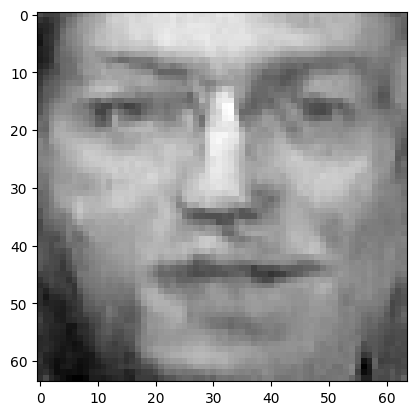

loss(generator):  0.09081774950027466
tensor([[3.2150e-04, 2.7277e-06, 9.1318e-01, 1.6712e-04, 4.8168e-07, 3.5687e-09,
         8.2511e-03, 1.5376e-05, 3.5276e-05, 2.2876e-04, 5.3114e-06, 5.1017e-05,
         5.3808e-03, 1.0020e-03, 1.0697e-08, 2.1429e-06, 1.5002e-03, 1.0174e-08,
         2.3552e-05, 6.4420e-06, 9.2938e-03, 3.2931e-03, 2.1105e-06, 2.8316e-05,
         2.9610e-04, 1.2846e-05, 1.3005e-05, 1.7316e-02, 5.5933e-03, 1.5772e-06,
         2.0555e-04, 3.3780e-08, 2.3981e-04, 1.7732e-05, 2.0605e-04, 8.0178e-07,
         1.2359e-02, 8.0816e-03, 7.2055e-04, 1.2141e-02]],
       grad_fn=<SoftmaxBackward>)


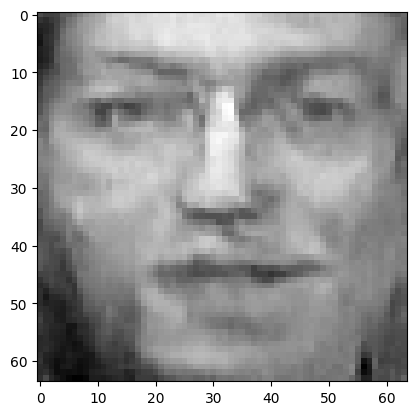

loss(generator):  0.08850659430027008
tensor([[3.1950e-04, 2.6077e-06, 9.1530e-01, 1.6354e-04, 4.6486e-07, 3.5277e-09,
         8.0384e-03, 1.5294e-05, 3.4266e-05, 2.2650e-04, 5.1427e-06, 4.9787e-05,
         5.2305e-03, 9.7303e-04, 1.0153e-08, 2.0898e-06, 1.4708e-03, 9.8217e-09,
         2.2852e-05, 6.2322e-06, 9.0434e-03, 3.1605e-03, 2.0770e-06, 2.7194e-05,
         2.8549e-04, 1.2589e-05, 1.2639e-05, 1.6987e-02, 5.4450e-03, 1.4996e-06,
         1.9440e-04, 3.2413e-08, 2.3026e-04, 1.6872e-05, 1.9937e-04, 7.6671e-07,
         1.2075e-02, 7.8920e-03, 6.9112e-04, 1.1864e-02]],
       grad_fn=<SoftmaxBackward>)


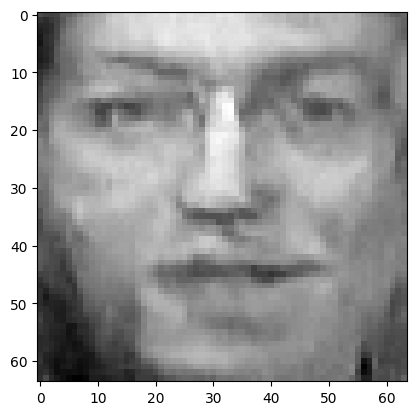

loss(generator):  0.08629102259874344
tensor([[3.1769e-04, 2.4949e-06, 9.1733e-01, 1.6009e-04, 4.4930e-07, 3.4908e-09,
         7.8348e-03, 1.5223e-05, 3.3307e-05, 2.2442e-04, 4.9833e-06, 4.8634e-05,
         5.0869e-03, 9.4542e-04, 9.6461e-09, 2.0394e-06, 1.4425e-03, 9.4945e-09,
         2.2194e-05, 6.0324e-06, 8.8025e-03, 3.0351e-03, 2.0455e-06, 2.6138e-05,
         2.7555e-04, 1.2350e-05, 1.2292e-05, 1.6665e-02, 5.3010e-03, 1.4275e-06,
         1.8407e-04, 3.1146e-08, 2.2124e-04, 1.6064e-05, 1.9310e-04, 7.3408e-07,
         1.1798e-02, 7.7112e-03, 6.6326e-04, 1.1605e-02]],
       grad_fn=<SoftmaxBackward>)


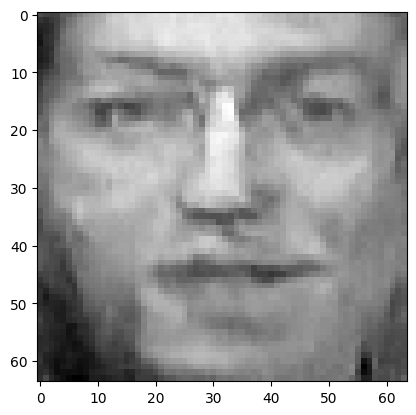

loss(generator):  0.08417365700006485
tensor([[3.1588e-04, 2.3893e-06, 9.1927e-01, 1.5679e-04, 4.3452e-07, 3.4530e-09,
         7.6386e-03, 1.5154e-05, 3.2377e-05, 2.2241e-04, 4.8321e-06, 4.7515e-05,
         4.9498e-03, 9.1897e-04, 9.1738e-09, 1.9903e-06, 1.4152e-03, 9.1766e-09,
         2.1570e-05, 5.8430e-06, 8.5725e-03, 2.9188e-03, 2.0146e-06, 2.5146e-05,
         2.6607e-04, 1.2121e-05, 1.1958e-05, 1.6353e-02, 5.1644e-03, 1.3605e-06,
         1.7453e-04, 2.9948e-08, 2.1277e-04, 1.5314e-05, 1.8718e-04, 7.0364e-07,
         1.1536e-02, 7.5357e-03, 6.3724e-04, 1.1352e-02]],
       grad_fn=<SoftmaxBackward>)


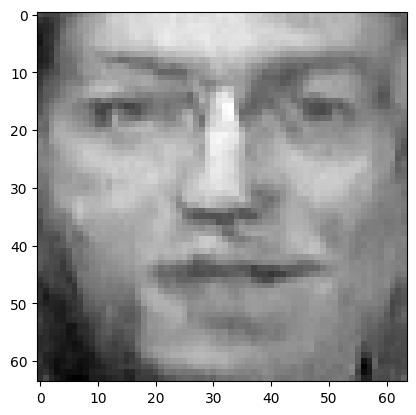

loss(generator):  0.08214602619409561
tensor([[3.1421e-04, 2.2899e-06, 9.2114e-01, 1.5361e-04, 4.2077e-07, 3.4187e-09,
         7.4515e-03, 1.5090e-05, 3.1496e-05, 2.2048e-04, 4.6879e-06, 4.6466e-05,
         4.8190e-03, 8.9394e-04, 8.7336e-09, 1.9438e-06, 1.3889e-03, 8.8827e-09,
         2.0976e-05, 5.6623e-06, 8.3529e-03, 2.8080e-03, 1.9854e-06, 2.4209e-05,
         2.5714e-04, 1.1905e-05, 1.1640e-05, 1.6050e-02, 5.0315e-03, 1.2978e-06,
         1.6566e-04, 2.8832e-08, 2.0477e-04, 1.4609e-05, 1.8157e-04, 6.7509e-07,
         1.1280e-02, 7.3687e-03, 6.1258e-04, 1.1112e-02]],
       grad_fn=<SoftmaxBackward>)


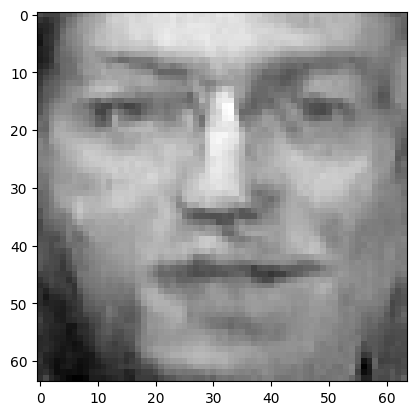

loss(generator):  0.08020371943712234
tensor([[3.1261e-04, 2.1964e-06, 9.2293e-01, 1.5055e-04, 4.0780e-07, 3.3861e-09,
         7.2723e-03, 1.5030e-05, 3.0656e-05, 2.1861e-04, 4.5506e-06, 4.5467e-05,
         4.6939e-03, 8.7003e-04, 8.3228e-09, 1.8996e-06, 1.3634e-03, 8.6061e-09,
         2.0410e-05, 5.4910e-06, 8.1431e-03, 2.7028e-03, 1.9572e-06, 2.3326e-05,
         2.4868e-04, 1.1697e-05, 1.1336e-05, 1.5756e-02, 4.9036e-03, 1.2394e-06,
         1.5740e-04, 2.7779e-08, 1.9721e-04, 1.3948e-05, 1.7624e-04, 6.4830e-07,
         1.1033e-02, 7.2085e-03, 5.8928e-04, 1.0883e-02]],
       grad_fn=<SoftmaxBackward>)


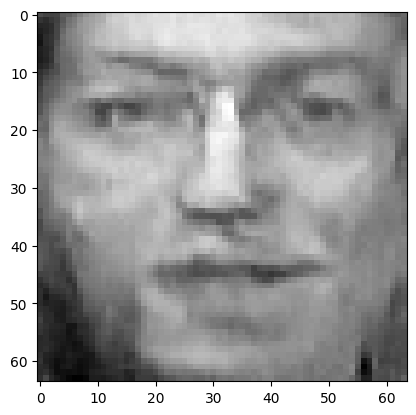

loss(generator):  0.07833413779735565
tensor([[3.1108e-04, 2.1086e-06, 9.2466e-01, 1.4756e-04, 3.9536e-07, 3.3558e-09,
         7.0970e-03, 1.4975e-05, 2.9849e-05, 2.1674e-04, 4.4198e-06, 4.4501e-05,
         4.5723e-03, 8.4699e-04, 7.9396e-09, 1.8565e-06, 1.3389e-03, 8.3405e-09,
         1.9865e-05, 5.3268e-06, 7.9399e-03, 2.6037e-03, 1.9298e-06, 2.2489e-05,
         2.4060e-04, 1.1498e-05, 1.1042e-05, 1.5471e-02, 4.7806e-03, 1.1844e-06,
         1.4969e-04, 2.6777e-08, 1.9000e-04, 1.3328e-05, 1.7113e-04, 6.2301e-07,
         1.0794e-02, 7.0518e-03, 5.6732e-04, 1.0668e-02]],
       grad_fn=<SoftmaxBackward>)


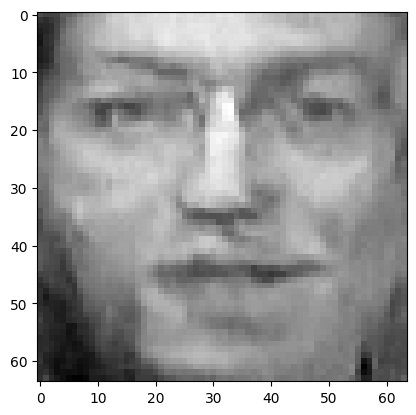

loss(generator):  0.07651184499263763
tensor([[3.1001e-04, 2.0247e-06, 9.2634e-01, 1.4467e-04, 3.8389e-07, 3.3353e-09,
         6.9278e-03, 1.4942e-05, 2.9101e-05, 2.1509e-04, 4.2946e-06, 4.3629e-05,
         4.4534e-03, 8.2487e-04, 7.5794e-09, 1.8163e-06, 1.3151e-03, 8.1089e-09,
         1.9342e-05, 5.1670e-06, 7.7403e-03, 2.5055e-03, 1.9060e-06, 2.1691e-05,
         2.3300e-04, 1.1317e-05, 1.0760e-05, 1.5186e-02, 4.6579e-03, 1.1322e-06,
         1.4233e-04, 2.5846e-08, 1.8303e-04, 1.2726e-05, 1.6627e-04, 5.9891e-07,
         1.0552e-02, 6.9033e-03, 5.4592e-04, 1.0471e-02]],
       grad_fn=<SoftmaxBackward>)


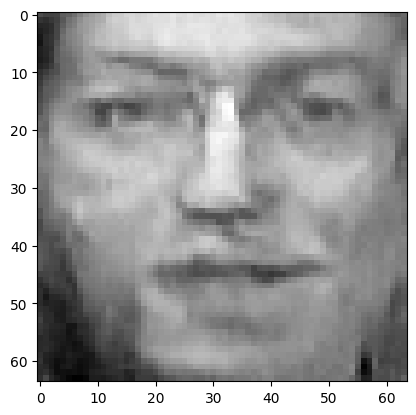

loss(generator):  0.07477439939975739
tensor([[3.0890e-04, 1.9458e-06, 9.2795e-01, 1.4192e-04, 3.7287e-07, 3.3144e-09,
         6.7651e-03, 1.4916e-05, 2.8382e-05, 2.1352e-04, 4.1762e-06, 4.2787e-05,
         4.3399e-03, 8.0377e-04, 7.2414e-09, 1.7775e-06, 1.2926e-03, 7.8851e-09,
         1.8840e-05, 5.0165e-06, 7.5503e-03, 2.4139e-03, 1.8826e-06, 2.0940e-05,
         2.2570e-04, 1.1146e-05, 1.0491e-05, 1.4913e-02, 4.5404e-03, 1.0832e-06,
         1.3548e-04, 2.4957e-08, 1.7645e-04, 1.2165e-05, 1.6166e-04, 5.7619e-07,
         1.0323e-02, 6.7596e-03, 5.2587e-04, 1.0279e-02]],
       grad_fn=<SoftmaxBackward>)


In [18]:
optimize_ddpm_noise_eps(x_i, 10, 0.2, 1, target=2)

In [19]:
torch.save(x_i, 'attack2.pt')

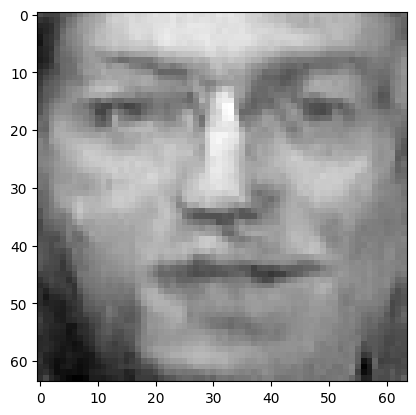

loss(generator):  0.07310972362756729
tensor([[3.0785e-04, 1.8715e-06, 9.2950e-01, 1.3927e-04, 3.6252e-07, 3.2949e-09,
         6.6096e-03, 1.4884e-05, 2.7684e-05, 2.1184e-04, 4.0621e-06, 4.2024e-05,
         4.2296e-03, 7.8445e-04, 6.9224e-09, 1.7381e-06, 1.2711e-03, 7.6710e-09,
         1.8359e-05, 4.8675e-06, 7.3687e-03, 2.3268e-03, 1.8612e-06, 2.0214e-05,
         2.1889e-04, 1.1004e-05, 1.0238e-05, 1.4654e-02, 4.4223e-03, 1.0360e-06,
         1.2915e-04, 2.4148e-08, 1.7007e-04, 1.1639e-05, 1.5718e-04, 5.5424e-07,
         1.0108e-02, 6.6231e-03, 5.0679e-04, 1.0090e-02]],
       grad_fn=<SoftmaxBackward>)


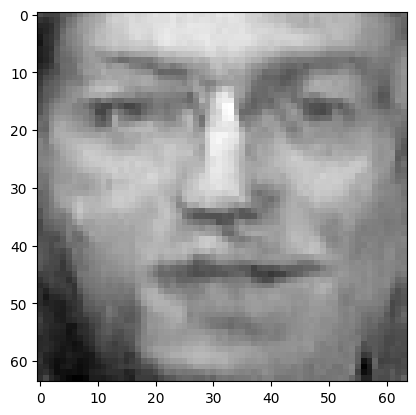

loss(generator):  0.06691743433475494
tensor([[3.0358e-04, 1.6070e-06, 9.3527e-01, 1.2937e-04, 3.2447e-07, 3.2150e-09,
         6.0302e-03, 1.4756e-05, 2.5085e-05, 2.0538e-04, 3.6412e-06, 3.9110e-05,
         3.8236e-03, 7.1218e-04, 5.8001e-09, 1.5931e-06, 1.1892e-03, 6.8752e-09,
         1.6586e-05, 4.3303e-06, 6.6978e-03, 2.0159e-03, 1.7753e-06, 1.7622e-05,
         1.9365e-04, 1.0443e-05, 9.2947e-06, 1.3669e-02, 3.9884e-03, 8.7048e-07,
         1.0706e-04, 2.1174e-08, 1.4726e-04, 9.7914e-06, 1.4076e-04, 4.7642e-07,
         9.3000e-03, 6.1042e-03, 4.3859e-04, 9.3742e-03]],
       grad_fn=<SoftmaxBackward>)


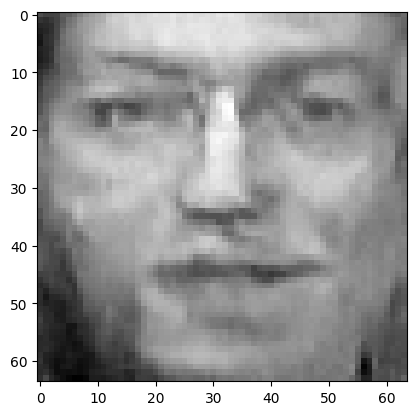

loss(generator):  0.06163511797785759
tensor([[2.9963e-04, 1.3962e-06, 9.4023e-01, 1.2078e-04, 2.9320e-07, 3.1452e-09,
         5.5368e-03, 1.4644e-05, 2.2885e-05, 1.9964e-04, 3.2881e-06, 3.6582e-05,
         3.4843e-03, 6.5066e-04, 4.9260e-09, 1.4722e-06, 1.1165e-03, 6.2157e-09,
         1.5097e-05, 3.8932e-06, 6.1316e-03, 1.7642e-03, 1.6958e-06, 1.5538e-05,
         1.7264e-04, 9.9326e-06, 8.4903e-06, 1.2797e-02, 3.6206e-03, 7.4216e-07,
         9.0018e-05, 1.8722e-08, 1.2892e-04, 8.3492e-06, 1.2708e-04, 4.1496e-07,
         8.5907e-03, 5.6524e-03, 3.8370e-04, 8.7626e-03]],
       grad_fn=<SoftmaxBackward>)


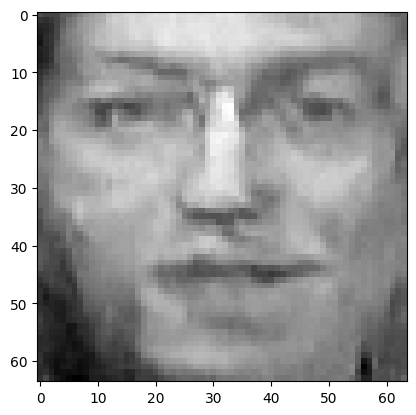

loss(generator):  0.057017385959625244
tensor([[2.9570e-04, 1.2223e-06, 9.4458e-01, 1.1320e-04, 2.6654e-07, 3.0813e-09,
         5.1054e-03, 1.4541e-05, 2.0977e-05, 1.9438e-04, 2.9856e-06, 3.4313e-05,
         3.1895e-03, 5.9674e-04, 4.2228e-09, 1.3675e-06, 1.0509e-03, 5.6505e-09,
         1.3813e-05, 3.5259e-06, 5.6399e-03, 1.5554e-03, 1.6223e-06, 1.3801e-05,
         1.5465e-04, 9.4609e-06, 7.7866e-06, 1.2012e-02, 3.3035e-03, 6.3894e-07,
         7.6387e-05, 1.6646e-08, 1.1373e-04, 7.1833e-06, 1.1541e-04, 3.6456e-07,
         7.9601e-03, 5.2508e-03, 3.3818e-04, 8.2224e-03]],
       grad_fn=<SoftmaxBackward>)


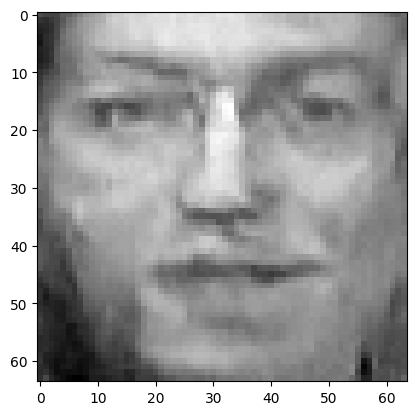

loss(generator):  0.05302216485142708
tensor([[2.9188e-04, 1.0797e-06, 9.4836e-01, 1.0654e-04, 2.4371e-07, 3.0174e-09,
         4.7314e-03, 1.4444e-05, 1.9313e-05, 1.8951e-04, 2.7267e-06, 3.2278e-05,
         2.9346e-03, 5.5004e-04, 3.6560e-09, 1.2760e-06, 9.9249e-04, 5.1597e-09,
         1.2709e-05, 3.2168e-06, 5.2182e-03, 1.3842e-03, 1.5537e-06, 1.2363e-05,
         1.3936e-04, 9.0280e-06, 7.1734e-06, 1.1318e-02, 3.0336e-03, 5.5580e-07,
         6.5539e-05, 1.4893e-08, 1.0121e-04, 6.2473e-06, 1.0554e-04, 3.2329e-07,
         7.4141e-03, 4.8964e-03, 3.0073e-04, 7.7436e-03]],
       grad_fn=<SoftmaxBackward>)


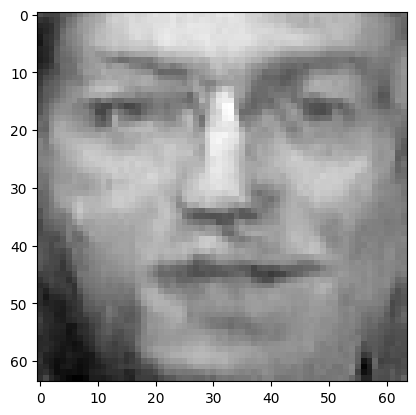

loss(generator):  0.049689121544361115
tensor([[2.8618e-04, 9.6790e-07, 9.5153e-01, 1.0080e-04, 2.2280e-07, 2.9147e-09,
         4.4044e-03, 1.4232e-05, 1.7751e-05, 1.8341e-04, 2.5073e-06, 3.0379e-05,
         2.7122e-03, 5.1323e-04, 3.1947e-09, 1.1840e-06, 9.4398e-04, 4.6534e-09,
         1.1749e-05, 2.9439e-06, 4.8709e-03, 1.2574e-03, 1.4852e-06, 1.1138e-05,
         1.2651e-04, 8.6968e-06, 6.6670e-06, 1.0773e-02, 2.8052e-03, 4.8572e-07,
         5.7432e-05, 1.3469e-08, 9.0740e-05, 5.5459e-06, 9.6740e-05, 2.8805e-07,
         7.0309e-03, 4.5804e-03, 2.7125e-04, 7.2539e-03]],
       grad_fn=<SoftmaxBackward>)


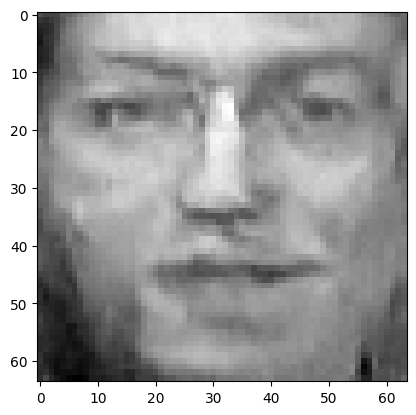

loss(generator):  0.04672544077038765
tensor([[2.8047e-04, 8.7295e-07, 9.5435e-01, 9.5627e-05, 2.0467e-07, 2.8160e-09,
         4.1146e-03, 1.4046e-05, 1.6393e-05, 1.7806e-04, 2.3179e-06, 2.8624e-05,
         2.5184e-03, 4.7939e-04, 2.8140e-09, 1.1065e-06, 8.9876e-04, 4.2171e-09,
         1.0915e-05, 2.7172e-06, 4.5639e-03, 1.1490e-03, 1.4186e-06, 1.0117e-05,
         1.1523e-04, 8.3534e-06, 6.2148e-06, 1.0273e-02, 2.6093e-03, 4.2913e-07,
         5.0684e-05, 1.2210e-08, 8.1995e-05, 4.9594e-06, 8.9184e-05, 2.5891e-07,
         6.6729e-03, 4.2929e-03, 2.4633e-04, 6.8322e-03]],
       grad_fn=<SoftmaxBackward>)


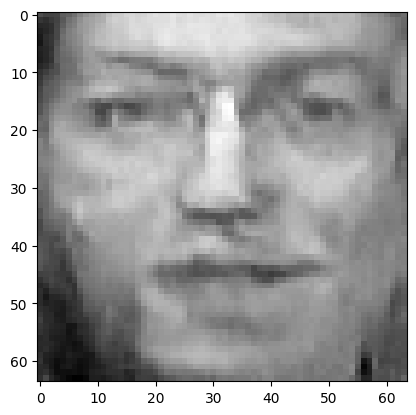

loss(generator):  0.0440751351416111
tensor([[2.7513e-04, 7.9124e-07, 9.5688e-01, 9.0936e-05, 1.8898e-07, 2.7263e-09,
         3.8577e-03, 1.3876e-05, 1.5201e-05, 1.7315e-04, 2.1508e-06, 2.7055e-05,
         2.3470e-03, 4.4924e-04, 2.4952e-09, 1.0382e-06, 8.5753e-04, 3.8439e-09,
         1.0179e-05, 2.5185e-06, 4.2908e-03, 1.0544e-03, 1.3577e-06, 9.2391e-06,
         1.0547e-04, 8.0376e-06, 5.8111e-06, 9.8134e-03, 2.4349e-03, 3.8180e-07,
         4.5013e-05, 1.1125e-08, 7.4504e-05, 4.4596e-06, 8.2608e-05, 2.3414e-07,
         6.3448e-03, 4.0368e-03, 2.2481e-04, 6.4572e-03]],
       grad_fn=<SoftmaxBackward>)


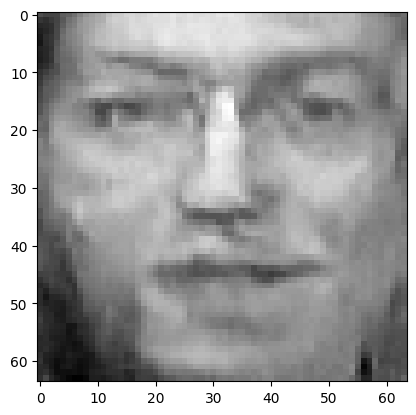

loss(generator):  0.04169510304927826
tensor([[2.7021e-04, 7.2048e-07, 9.5916e-01, 8.6659e-05, 1.7534e-07, 2.6447e-09,
         3.6289e-03, 1.3728e-05, 1.4155e-05, 1.6875e-04, 2.0031e-06, 2.5651e-05,
         2.1953e-03, 4.2199e-04, 2.2261e-09, 9.7886e-07, 8.1987e-04, 3.5243e-09,
         9.5274e-06, 2.3454e-06, 4.0471e-03, 9.7129e-04, 1.3013e-06, 8.4854e-06,
         9.6927e-05, 7.7375e-06, 5.4488e-06, 9.3887e-03, 2.2805e-03, 3.4215e-07,
         4.0200e-05, 1.0176e-08, 6.8069e-05, 4.0300e-06, 7.6874e-05, 2.1305e-07,
         6.0402e-03, 3.8065e-03, 2.0613e-04, 6.1269e-03]],
       grad_fn=<SoftmaxBackward>)


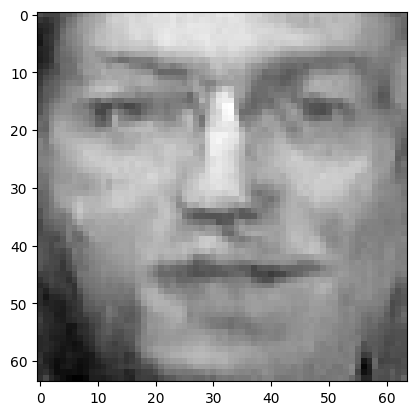

loss(generator):  0.039530228823423386
tensor([[2.6548e-04, 6.5857e-07, 9.6124e-01, 8.2753e-05, 1.6336e-07, 2.5709e-09,
         3.4228e-03, 1.3603e-05, 1.3228e-05, 1.6476e-04, 1.8720e-06, 2.4384e-05,
         2.0583e-03, 3.9718e-04, 1.9969e-09, 9.2661e-07, 7.8496e-04, 3.2474e-09,
         8.9484e-06, 2.1934e-06, 3.8267e-03, 8.9745e-04, 1.2489e-06, 7.8298e-06,
         8.9369e-05, 7.4580e-06, 5.1217e-06, 8.9953e-03, 2.1408e-03, 3.0836e-07,
         3.6063e-05, 9.3430e-09, 6.2436e-05, 3.6562e-06, 7.1785e-05, 1.9482e-07,
         5.7534e-03, 3.5965e-03, 1.8975e-04, 5.8317e-03]],
       grad_fn=<SoftmaxBackward>)


In [20]:
optimize_ddpm_noise_eps(x_i, 10, 0.8, 1, target=2)

In [21]:
torch.save(x_i, 'attack2.pt')

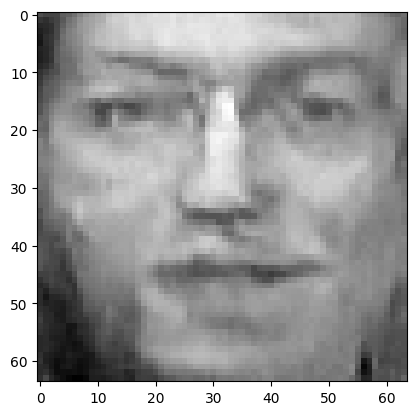

loss(generator):  0.03756608068943024
tensor([[2.6109e-04, 6.0426e-07, 9.6313e-01, 7.9180e-05, 1.5280e-07, 2.5032e-09,
         3.2373e-03, 1.3491e-05, 1.2401e-05, 1.6111e-04, 1.7544e-06, 2.3235e-05,
         1.9354e-03, 3.7466e-04, 1.8003e-09, 8.7996e-07, 7.5295e-04, 3.0053e-09,
         8.4289e-06, 2.0582e-06, 3.6279e-03, 8.3203e-04, 1.2004e-06, 7.2555e-06,
         8.2681e-05, 7.1968e-06, 4.8251e-06, 8.6305e-03, 2.0152e-03, 2.7939e-07,
         3.2506e-05, 8.6091e-09, 5.7515e-05, 3.3308e-06, 6.7275e-05, 1.7900e-07,
         5.4885e-03, 3.4061e-03, 1.7533e-04, 5.5649e-03]],
       grad_fn=<SoftmaxBackward>)


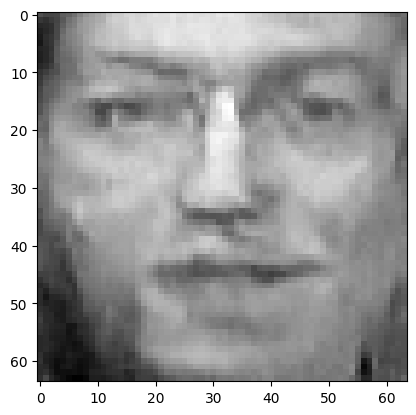

loss(generator):  0.033277202397584915
tensor([[2.5122e-04, 4.9222e-07, 9.6727e-01, 7.1229e-05, 1.3053e-07, 2.3497e-09,
         2.8342e-03, 1.3236e-05, 1.0621e-05, 1.5272e-04, 1.5005e-06, 2.0723e-05,
         1.6732e-03, 3.2596e-04, 1.4051e-09, 7.7878e-07, 6.8137e-04, 2.4990e-09,
         7.3036e-06, 1.7689e-06, 3.1974e-03, 6.9448e-04, 1.0904e-06, 6.0559e-06,
         6.8639e-05, 6.6095e-06, 4.1797e-06, 7.8094e-03, 1.7429e-03, 2.2110e-07,
         2.5399e-05, 7.0785e-09, 4.7336e-05, 2.6676e-06, 5.7680e-05, 1.4645e-07,
         4.8995e-03, 2.9914e-03, 1.4525e-04, 4.9830e-03]],
       grad_fn=<SoftmaxBackward>)


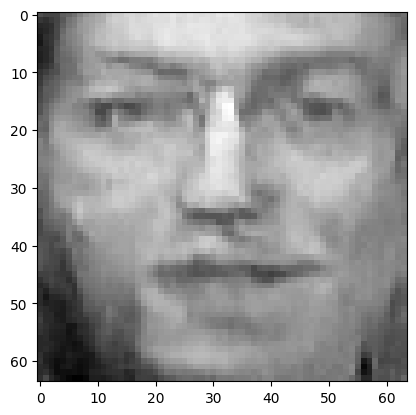

loss(generator):  0.029854323714971542
tensor([[2.4205e-04, 4.0986e-07, 9.7059e-01, 6.4717e-05, 1.1338e-07, 2.2104e-09,
         2.5170e-03, 1.2997e-05, 9.2281e-06, 1.4550e-04, 1.3029e-06, 1.8651e-05,
         1.4704e-03, 2.8735e-04, 1.1277e-09, 6.9990e-07, 6.2144e-04, 2.1141e-09,
         6.4252e-06, 1.5515e-06, 2.8622e-03, 5.9217e-04, 9.9445e-07, 5.1701e-06,
         5.7969e-05, 6.0903e-06, 3.6680e-06, 7.1275e-03, 1.5333e-03, 1.8038e-07,
         2.0413e-05, 5.9170e-09, 3.9924e-05, 2.1950e-06, 5.0360e-05, 1.2292e-07,
         4.4161e-03, 2.6561e-03, 1.2305e-04, 4.5155e-03]],
       grad_fn=<SoftmaxBackward>)


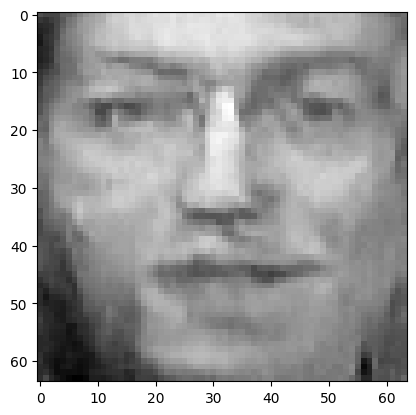

loss(generator):  0.027058854699134827
tensor([[2.3414e-04, 3.4701e-07, 9.7330e-01, 5.9313e-05, 9.9868e-08, 2.0924e-09,
         2.2611e-03, 1.2786e-05, 8.1209e-06, 1.3918e-04, 1.1446e-06, 1.6965e-05,
         1.3083e-03, 2.5642e-04, 9.2301e-10, 6.3544e-07, 5.7157e-04, 1.8174e-09,
         5.7189e-06, 1.3764e-06, 2.5902e-03, 5.1233e-04, 9.1421e-07, 4.4807e-06,
         4.9738e-05, 5.6570e-06, 3.2559e-06, 6.5574e-03, 1.3631e-03, 1.4999e-07,
         1.6752e-05, 5.0306e-09, 3.4223e-05, 1.8387e-06, 4.4532e-05, 1.0487e-07,
         4.0154e-03, 2.3840e-03, 1.0586e-04, 4.1289e-03]],
       grad_fn=<SoftmaxBackward>)


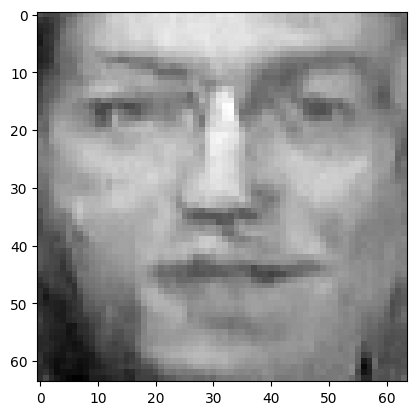

loss(generator):  0.024746086448431015
tensor([[2.2672e-04, 2.9837e-07, 9.7556e-01, 5.4797e-05, 8.8809e-08, 1.9815e-09,
         2.0505e-03, 1.2588e-05, 7.2164e-06, 1.3361e-04, 1.0167e-06, 1.5511e-05,
         1.1770e-03, 2.3073e-04, 7.6918e-10, 5.8231e-07, 5.2867e-04, 1.5779e-09,
         5.1440e-06, 1.2374e-06, 2.3673e-03, 4.5024e-04, 8.4333e-07, 3.9404e-06,
         4.3151e-05, 5.2636e-06, 2.9148e-06, 6.0747e-03, 1.2271e-03, 1.2714e-07,
         1.4000e-05, 4.3232e-09, 2.9822e-05, 1.5681e-06, 3.9831e-05, 9.0952e-08,
         3.6799e-03, 2.1574e-03, 9.2438e-05, 3.8062e-03]],
       grad_fn=<SoftmaxBackward>)


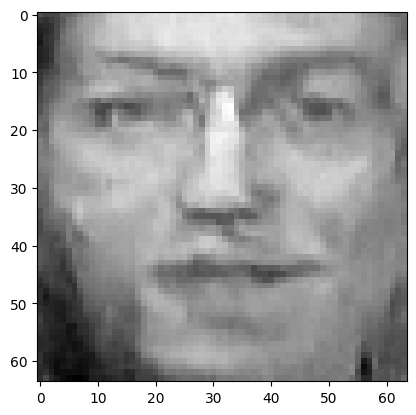

loss(generator):  0.022782720625400543
tensor([[2.1979e-04, 2.5940e-07, 9.7747e-01, 5.0902e-05, 7.9674e-08, 1.8809e-09,
         1.8736e-03, 1.2398e-05, 6.4628e-06, 1.2854e-04, 9.1040e-07, 1.4261e-05,
         1.0675e-03, 2.0921e-04, 6.4960e-10, 5.3696e-07, 4.9165e-04, 1.3824e-09,
         4.6609e-06, 1.1218e-06, 2.1791e-03, 3.9992e-04, 7.8113e-07, 3.5009e-06,
         3.7805e-05, 4.9178e-06, 2.6275e-06, 5.6563e-03, 1.1132e-03, 1.0919e-07,
         1.1870e-05, 3.7540e-09, 2.6288e-05, 1.3548e-06, 3.5945e-05, 7.9802e-08,
         3.3939e-03, 1.9653e-03, 8.1611e-05, 3.5288e-03]],
       grad_fn=<SoftmaxBackward>)


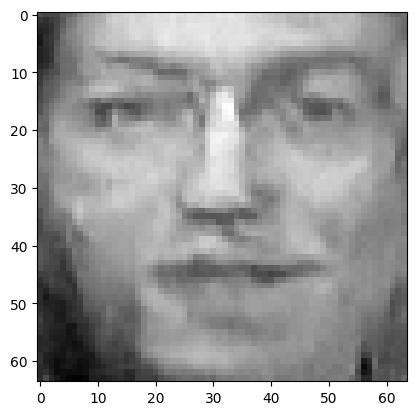

loss(generator):  0.021094726398587227
tensor([[2.1433e-04, 2.2768e-07, 9.7913e-01, 4.7438e-05, 7.2436e-08, 1.8036e-09,
         1.7232e-03, 1.2253e-05, 5.8436e-06, 1.2429e-04, 8.2122e-07, 1.3238e-05,
         9.7600e-04, 1.9113e-04, 5.5557e-10, 4.9961e-07, 4.5940e-04, 1.2315e-09,
         4.2514e-06, 1.0242e-06, 2.0174e-03, 3.5701e-04, 7.2923e-07, 3.1370e-06,
         3.3494e-05, 4.6226e-06, 2.3847e-06, 5.2822e-03, 1.0139e-03, 9.5026e-08,
         1.0184e-05, 3.2996e-09, 2.3389e-05, 1.1806e-06, 3.2743e-05, 7.0838e-08,
         3.1376e-03, 1.8047e-03, 7.2577e-05, 3.3025e-03]],
       grad_fn=<SoftmaxBackward>)


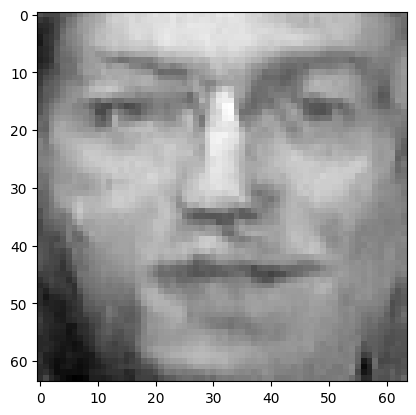

loss(generator):  0.019638624042272568
tensor([[2.0941e-04, 2.0165e-07, 9.8055e-01, 4.4447e-05, 6.6539e-08, 1.7364e-09,
         1.5953e-03, 1.2117e-05, 5.3249e-06, 1.2048e-04, 7.4576e-07, 1.2393e-05,
         8.9762e-04, 1.7596e-04, 4.8111e-10, 4.6723e-07, 4.3150e-04, 1.1085e-09,
         3.9073e-06, 9.4130e-07, 1.8807e-03, 3.2113e-04, 6.8491e-07, 2.8375e-06,
         2.9946e-05, 4.3771e-06, 2.1802e-06, 4.9558e-03, 9.2693e-04, 8.3530e-08,
         8.8487e-06, 2.9332e-09, 2.0972e-05, 1.0391e-06, 3.0050e-05, 6.3491e-08,
         2.9143e-03, 1.6657e-03, 6.5106e-05, 3.1056e-03]],
       grad_fn=<SoftmaxBackward>)


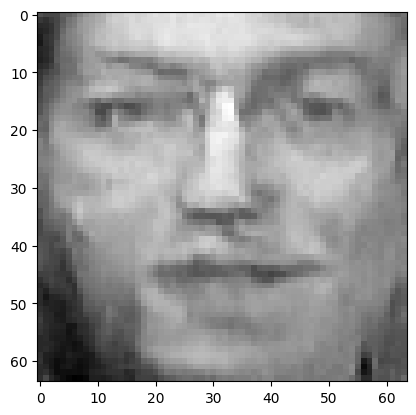

loss(generator):  0.01835433579981327
tensor([[2.0495e-04, 1.7979e-07, 9.8181e-01, 4.1787e-05, 6.1461e-08, 1.6770e-09,
         1.4831e-03, 1.1997e-05, 4.8785e-06, 1.1704e-04, 6.8082e-07, 1.1647e-05,
         8.2905e-04, 1.6269e-04, 4.1996e-10, 4.3885e-07, 4.0660e-04, 1.0045e-09,
         3.6083e-06, 8.6952e-07, 1.7597e-03, 2.9044e-04, 6.4548e-07, 2.5807e-06,
         2.6932e-05, 4.1558e-06, 2.0025e-06, 4.6627e-03, 8.5134e-04, 7.4007e-08,
         7.7458e-06, 2.6242e-09, 1.8924e-05, 9.2078e-07, 2.7719e-05, 5.7292e-08,
         2.7160e-03, 1.5447e-03, 5.8738e-05, 2.9319e-03]],
       grad_fn=<SoftmaxBackward>)


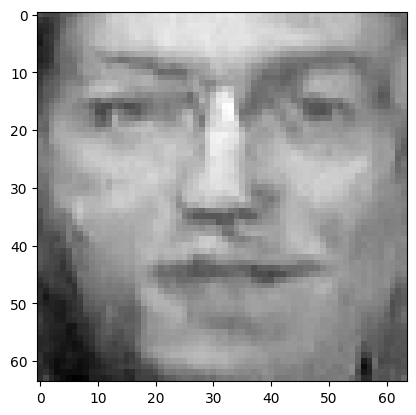

loss(generator):  0.01721581257879734
tensor([[2.0075e-04, 1.6126e-07, 9.8293e-01, 3.9408e-05, 5.7009e-08, 1.6217e-09,
         1.3840e-03, 1.1882e-05, 4.4890e-06, 1.1384e-04, 6.2441e-07, 1.0975e-05,
         7.6885e-04, 1.5103e-04, 3.6924e-10, 4.1341e-07, 3.8429e-04, 9.1466e-10,
         3.3456e-06, 8.0662e-07, 1.6524e-03, 2.6417e-04, 6.0999e-07, 2.3590e-06,
         2.4352e-05, 3.9549e-06, 1.8466e-06, 4.3998e-03, 7.8552e-04, 6.6013e-08,
         6.8293e-06, 2.3608e-09, 1.7177e-05, 8.2141e-07, 2.5689e-05, 5.1996e-08,
         2.5409e-03, 1.4383e-03, 5.3298e-05, 2.7755e-03]],
       grad_fn=<SoftmaxBackward>)


In [22]:
optimize_ddpm_noise_eps(x_i, 10, 2, 1, target=2)

In [23]:
torch.save(x_i, 'attack2.pt')

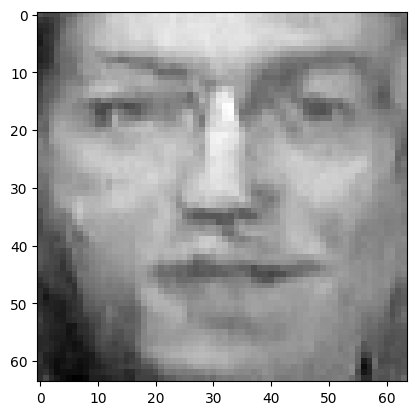

loss(generator):  0.016202442348003387
tensor([[1.9692e-04, 1.4543e-07, 9.8393e-01, 3.7276e-05, 5.3084e-08, 1.5709e-09,
         1.2960e-03, 1.1777e-05, 4.1478e-06, 1.1090e-04, 5.7506e-07, 1.0372e-05,
         7.1578e-04, 1.4071e-04, 3.2679e-10, 3.9059e-07, 3.6424e-04, 8.3696e-10,
         3.1137e-06, 7.5125e-07, 1.5568e-03, 2.4146e-04, 5.7808e-07, 2.1667e-06,
         2.2126e-05, 3.7717e-06, 1.7092e-06, 4.1627e-03, 7.2794e-04, 5.9241e-08,
         6.0591e-06, 2.1344e-09, 1.5673e-05, 7.3707e-07, 2.3912e-05, 4.7436e-08,
         2.3853e-03, 1.3442e-03, 4.8611e-05, 2.6346e-03]],
       grad_fn=<SoftmaxBackward>)


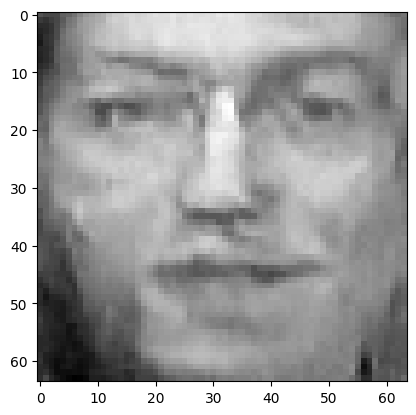

loss(generator):  0.012144903652369976
tensor([[1.8044e-04, 8.8752e-08, 9.8793e-01, 2.8659e-05, 3.7902e-08, 1.3592e-09,
         9.4919e-04, 1.1321e-05, 2.8599e-06, 9.8114e-05, 3.8766e-07, 7.9316e-06,
         5.0834e-04, 1.0017e-04, 1.8330e-10, 2.9657e-07, 2.8175e-04, 5.4816e-10,
         2.2074e-06, 5.3417e-07, 1.1711e-03, 1.5758e-04, 4.5166e-07, 1.4380e-06,
         1.4011e-05, 3.0302e-06, 1.1758e-06, 3.1863e-03, 5.0452e-04, 3.5463e-08,
         3.4263e-06, 1.3239e-09, 1.0163e-05, 4.4014e-07, 1.7088e-05, 3.0673e-08,
         1.7691e-03, 9.8061e-04, 3.1448e-05, 2.0472e-03]],
       grad_fn=<SoftmaxBackward>)


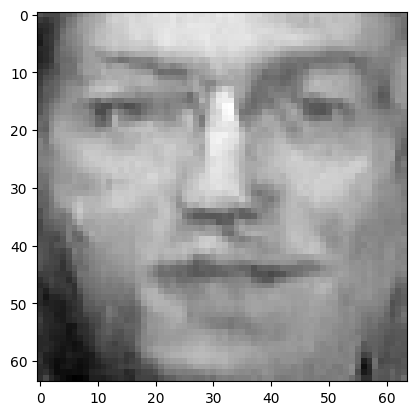

loss(generator):  0.00976322777569294
tensor([[1.6802e-04, 6.0969e-08, 9.9028e-01, 2.3652e-05, 2.8970e-08, 1.2037e-09,
         7.5010e-04, 1.0942e-05, 2.1424e-06, 8.8298e-05, 2.8609e-07, 6.4373e-06,
         3.9047e-04, 7.7881e-05, 1.1798e-10, 2.3608e-07, 2.3245e-04, 3.9089e-10,
         1.6910e-06, 4.0781e-07, 9.4527e-04, 1.1500e-04, 3.7510e-07, 1.0481e-06,
         9.8844e-06, 2.5912e-06, 8.8111e-07, 2.5983e-03, 3.8192e-04, 2.3699e-08,
         2.2248e-06, 9.2283e-10, 7.3136e-06, 2.9948e-07, 1.3256e-05, 2.1795e-08,
         1.4293e-03, 7.7402e-04, 2.2767e-05, 1.6583e-03]],
       grad_fn=<SoftmaxBackward>)


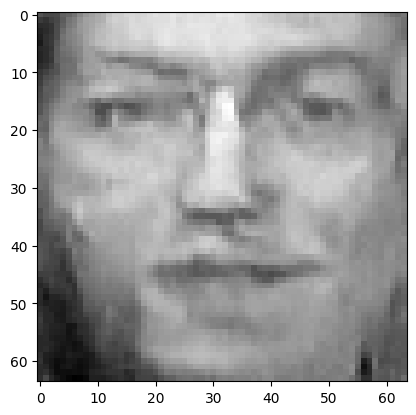

loss(generator):  0.008149584755301476
tensor([[1.5799e-04, 4.4724e-08, 9.9188e-01, 2.0201e-05, 2.3194e-08, 1.0837e-09,
         6.1836e-04, 1.0617e-05, 1.6825e-06, 8.0721e-05, 2.2197e-07, 5.4458e-06,
         3.1181e-04, 6.3455e-05, 8.1886e-11, 1.9439e-07, 1.9825e-04, 2.9434e-10,
         1.3615e-06, 3.2546e-07, 7.9346e-04, 8.9064e-05, 3.2132e-07, 8.0786e-07,
         7.3947e-06, 2.2931e-06, 6.9331e-07, 2.1902e-03, 3.0201e-04, 1.6924e-08,
         1.5627e-06, 6.8652e-10, 5.5663e-06, 2.1851e-07, 1.0761e-05, 1.6405e-08,
         1.2002e-03, 6.3593e-04, 1.7434e-05, 1.3878e-03]],
       grad_fn=<SoftmaxBackward>)


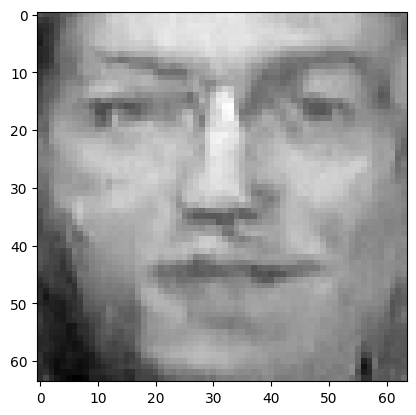

loss(generator):  0.007004704792052507
tensor([[1.4911e-04, 3.4489e-08, 9.9302e-01, 1.7689e-05, 1.9084e-08, 9.8218e-10,
         5.2757e-04, 1.0328e-05, 1.3676e-06, 7.4566e-05, 1.7899e-07, 4.7216e-06,
         2.5749e-04, 5.3409e-05, 6.0112e-11, 1.6419e-07, 1.7349e-04, 2.2953e-10,
         1.1341e-06, 2.6846e-07, 6.8570e-04, 7.2381e-05, 2.8056e-07, 6.4988e-07,
         5.7853e-06, 2.0701e-06, 5.6608e-07, 1.8957e-03, 2.4894e-04, 1.2732e-08,
         1.1672e-06, 5.3434e-10, 4.4432e-06, 1.6852e-07, 9.0393e-06, 1.2865e-08,
         1.0409e-03, 5.3886e-04, 1.3960e-05, 1.1879e-03]],
       grad_fn=<SoftmaxBackward>)


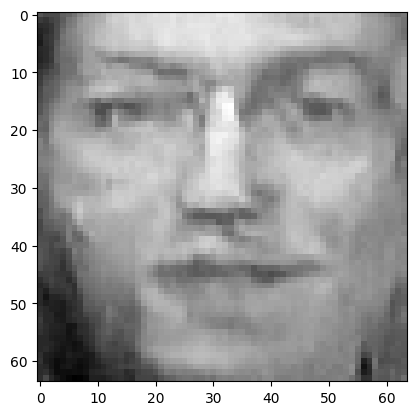

loss(generator):  0.006147878710180521
tensor([[1.4079e-04, 2.7582e-08, 9.9387e-01, 1.5750e-05, 1.6016e-08, 8.9338e-10,
         4.6007e-04, 1.0045e-05, 1.1382e-06, 6.9359e-05, 1.4859e-07, 4.1551e-06,
         2.1782e-04, 4.6001e-05, 4.5969e-11, 1.4144e-07, 1.5450e-04, 1.8309e-10,
         9.6733e-07, 2.2708e-07, 6.0475e-04, 6.0791e-05, 2.4779e-07, 5.3835e-07,
         4.6715e-06, 1.8909e-06, 4.7492e-07, 1.6747e-03, 2.1117e-04, 9.9488e-09,
         9.1015e-07, 4.2908e-10, 3.6595e-06, 1.3517e-07, 7.7550e-06, 1.0398e-08,
         9.2263e-04, 4.6575e-04, 1.1537e-05, 1.0363e-03]],
       grad_fn=<SoftmaxBackward>)


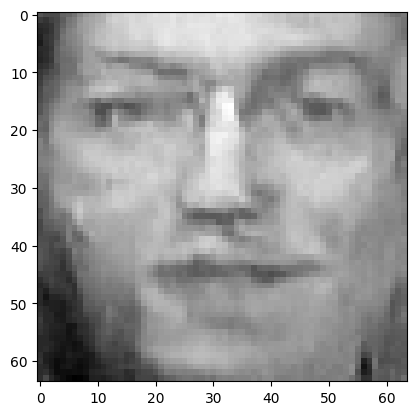

loss(generator):  0.005478843115270138
tensor([[1.3370e-04, 2.2645e-08, 9.9454e-01, 1.4208e-05, 1.3746e-08, 8.2335e-10,
         4.0819e-04, 9.7960e-06, 9.6740e-07, 6.4941e-05, 1.2595e-07, 3.7255e-06,
         1.8746e-04, 4.0451e-05, 3.6240e-11, 1.2379e-07, 1.3940e-04, 1.5008e-10,
         8.4100e-07, 1.9532e-07, 5.4093e-04, 5.2040e-05, 2.2211e-07, 4.5509e-07,
         3.8719e-06, 1.7566e-06, 4.0707e-07, 1.5010e-03, 1.8165e-04, 7.9813e-09,
         7.3205e-07, 3.5485e-10, 3.0747e-06, 1.1119e-07, 6.7574e-06, 8.5969e-09,
         8.2849e-04, 4.0976e-04, 9.7321e-06, 9.1882e-04]],
       grad_fn=<SoftmaxBackward>)


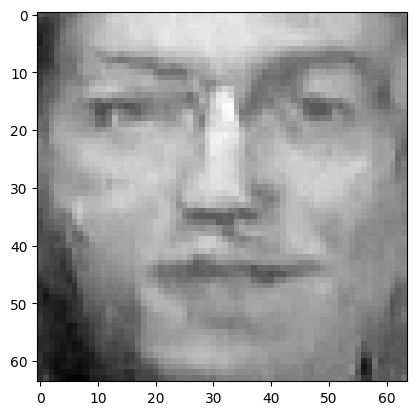

loss(generator):  0.0049435291439294815
tensor([[1.2673e-04, 1.8976e-08, 9.9507e-01, 1.2971e-05, 1.1859e-08, 7.5543e-10,
         3.6620e-04, 9.5250e-06, 8.3295e-07, 6.0939e-05, 1.0866e-07, 3.3537e-06,
         1.6374e-04, 3.6008e-05, 2.9279e-11, 1.0916e-07, 1.2711e-04, 1.2403e-10,
         7.4112e-07, 1.7063e-07, 4.8980e-04, 4.5513e-05, 2.0049e-07, 3.9151e-07,
         3.2599e-06, 1.6375e-06, 3.5441e-07, 1.3646e-03, 1.5949e-04, 6.5278e-09,
         6.0225e-07, 2.9760e-10, 2.6294e-06, 9.3669e-08, 5.9557e-06, 7.2266e-09,
         7.5641e-04, 3.6411e-04, 8.3852e-06, 8.1920e-04]],
       grad_fn=<SoftmaxBackward>)


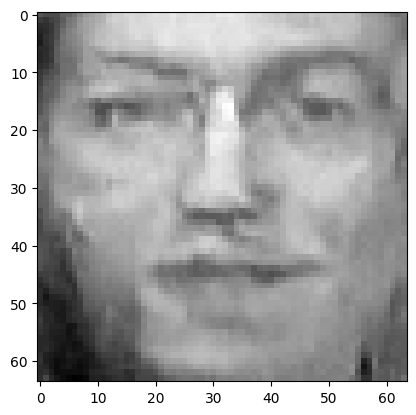

loss(generator):  0.004500142764300108
tensor([[1.2064e-04, 1.6148e-08, 9.9551e-01, 1.1926e-05, 1.0369e-08, 6.9893e-10,
         3.3171e-04, 9.2924e-06, 7.2718e-07, 5.7586e-05, 9.5027e-08, 3.0465e-06,
         1.4468e-04, 3.2345e-05, 2.4104e-11, 9.7567e-08, 1.1670e-04, 1.0435e-10,
         6.6075e-07, 1.5107e-07, 4.4706e-04, 4.0248e-05, 1.8240e-07, 3.4160e-07,
         2.7851e-06, 1.5324e-06, 3.1227e-07, 1.2500e-03, 1.4167e-04, 5.4447e-09,
         5.0365e-07, 2.5317e-10, 2.2806e-06, 8.0073e-08, 5.3094e-06, 6.1762e-09,
         6.9449e-04, 3.2678e-04, 7.3150e-06, 7.3940e-04]],
       grad_fn=<SoftmaxBackward>)


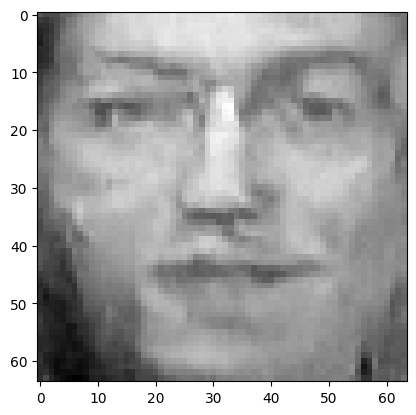

loss(generator):  0.0041285050101578236
tensor([[1.1519e-04, 1.3933e-08, 9.9588e-01, 1.1040e-05, 9.1619e-09, 6.4973e-10,
         3.0287e-04, 9.0821e-06, 6.4186e-07, 5.4702e-05, 8.4050e-08, 2.7857e-06,
         1.2915e-04, 2.9282e-05, 2.0183e-11, 8.8069e-08, 1.0779e-04, 8.8989e-11,
         5.9502e-07, 1.3535e-07, 4.1128e-04, 3.5994e-05, 1.6700e-07, 3.0179e-07,
         2.4085e-06, 1.4381e-06, 2.7791e-07, 1.1529e-03, 1.2726e-04, 4.6191e-09,
         4.2749e-07, 2.1787e-10, 2.0037e-06, 6.9419e-08, 4.7810e-06, 5.3557e-09,
         6.4181e-04, 2.9573e-04, 6.4588e-06, 6.7333e-04]],
       grad_fn=<SoftmaxBackward>)


In [24]:
optimize_ddpm_noise_eps(x_i, 10, 10, 1, target=2)

In [25]:
torch.save(x_i, 'attack2.pt')

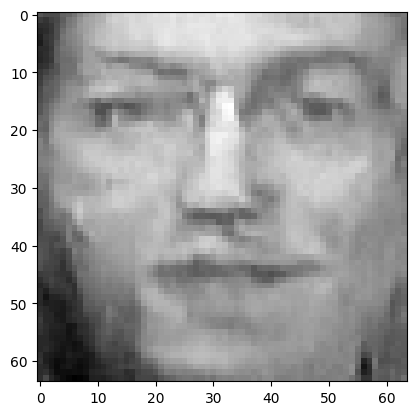

loss(generator):  0.003815040225163102
tensor([[1.1029e-04, 1.2172e-08, 9.9619e-01, 1.0285e-05, 8.1736e-09, 6.0670e-10,
         2.7852e-04, 8.8901e-06, 5.7235e-07, 5.2217e-05, 7.5116e-08, 2.5643e-06,
         1.1629e-04, 2.6703e-05, 1.7160e-11, 8.0160e-08, 1.0016e-04, 7.6828e-11,
         5.4067e-07, 1.2252e-07, 3.8115e-04, 3.2525e-05, 1.5399e-07, 2.6959e-07,
         2.1071e-06, 1.3545e-06, 2.4966e-07, 1.0704e-03, 1.1548e-04, 3.9758e-09,
         3.6765e-07, 1.8954e-10, 1.7803e-06, 6.0929e-08, 4.3445e-06, 4.7009e-09,
         5.9699e-04, 2.6974e-04, 5.7654e-06, 6.1772e-04]],
       grad_fn=<SoftmaxBackward>)


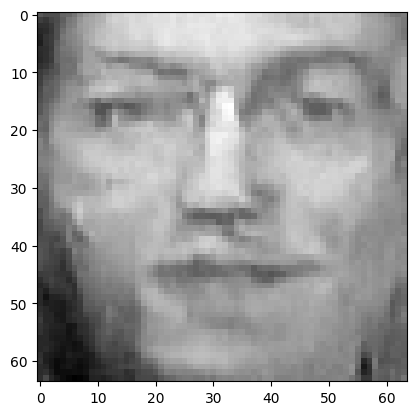

loss(generator):  0.0018230738351121545
tensor([[7.1924e-05, 3.3970e-09, 9.9818e-01, 5.2362e-06, 2.7396e-09, 3.1238e-10,
         1.2775e-04, 7.2713e-06, 1.9470e-07, 3.4095e-05, 2.6289e-08, 1.1568e-06,
         4.2670e-05, 1.0938e-05, 3.7649e-12, 3.3204e-08, 4.9205e-05, 1.9048e-11,
         2.2303e-07, 4.9061e-08, 1.8588e-04, 1.2666e-05, 7.0815e-08, 9.4720e-08,
         5.9482e-07, 7.4821e-07, 8.9756e-08, 5.2936e-04, 4.7060e-05, 9.8608e-10,
         8.8173e-08, 4.9368e-11, 5.8981e-07, 1.7924e-08, 1.7888e-06, 1.4045e-09,
         2.9749e-04, 1.1243e-04, 1.9849e-06, 2.7963e-04]],
       grad_fn=<SoftmaxBackward>)


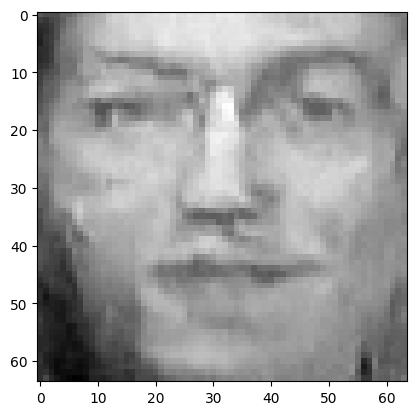

loss(generator):  0.001260320539586246
tensor([[5.7383e-05, 1.7802e-09, 9.9874e-01, 3.6976e-06, 1.5745e-09, 2.2504e-10,
         8.8353e-05, 6.5352e-06, 1.1385e-07, 2.7122e-05, 1.5463e-08, 7.7529e-07,
         2.5750e-05, 7.0343e-06, 1.7498e-12, 2.1138e-08, 3.4058e-05, 9.5683e-12,
         1.4290e-07, 3.0612e-08, 1.2813e-04, 7.8661e-06, 4.7645e-08, 5.5552e-08,
         3.2092e-07, 5.5930e-07, 5.3633e-08, 3.6912e-04, 2.9757e-05, 4.8968e-10,
         4.3272e-08, 2.5296e-11, 3.4050e-07, 9.6793e-09, 1.1449e-06, 7.6338e-10,
         2.0809e-04, 7.3844e-05, 1.1577e-06, 1.8801e-04]],
       grad_fn=<SoftmaxBackward>)


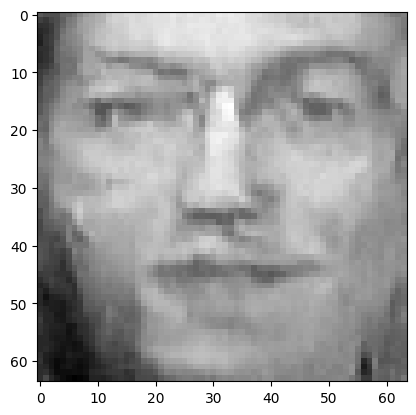

loss(generator):  0.0009659630013629794
tensor([[4.8459e-05, 1.1146e-09, 9.9903e-01, 2.8726e-06, 1.0552e-09, 1.7739e-10,
         6.8059e-05, 6.0316e-06, 7.7325e-08, 2.2943e-05, 1.0529e-08, 5.8101e-07,
         1.7855e-05, 5.1124e-06, 1.0055e-12, 1.5254e-08, 2.6016e-05, 5.8229e-12,
         1.0385e-07, 2.1779e-08, 9.7716e-05, 5.5711e-06, 3.5661e-08, 3.7837e-08,
         2.0594e-07, 4.5330e-07, 3.6998e-08, 2.8417e-04, 2.1288e-05, 2.9546e-10,
         2.5904e-08, 1.5613e-11, 2.2883e-07, 6.2019e-09, 8.2835e-07, 4.9232e-10,
         1.6010e-04, 5.4428e-05, 7.8331e-07, 1.4135e-04]],
       grad_fn=<SoftmaxBackward>)


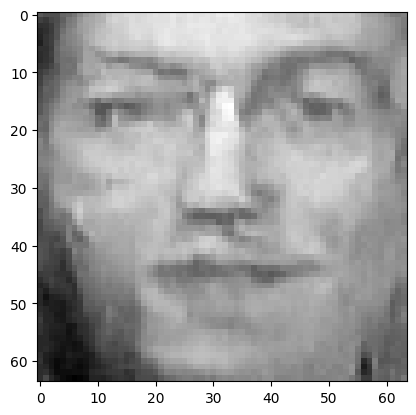

loss(generator):  0.0007849234389141202
tensor([[4.1822e-05, 7.7338e-10, 9.9922e-01, 2.3605e-06, 7.6312e-10, 1.4449e-10,
         5.5577e-05, 5.6205e-06, 5.7063e-08, 2.0051e-05, 7.8129e-09, 4.5821e-07,
         1.3427e-05, 3.9579e-06, 6.5451e-13, 1.1826e-08, 2.0948e-05, 3.9000e-12,
         8.1095e-08, 1.6829e-08, 7.9301e-05, 4.2854e-06, 2.8055e-08, 2.8192e-08,
         1.4504e-07, 3.7878e-07, 2.7647e-08, 2.3187e-04, 1.6538e-05, 2.0044e-10,
         1.7370e-08, 1.0587e-11, 1.6869e-07, 4.4095e-09, 6.4228e-07, 3.5052e-10,
         1.3048e-04, 4.2716e-05, 5.8065e-07, 1.1300e-04]],
       grad_fn=<SoftmaxBackward>)


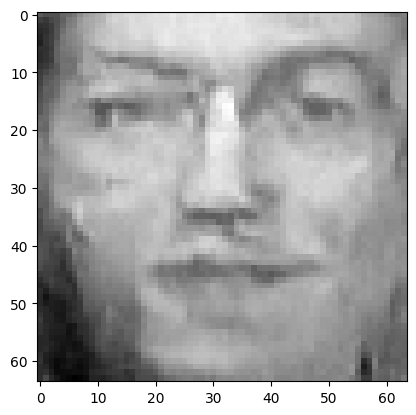

loss(generator):  0.0006586528033949435
tensor([[3.6717e-05, 5.6848e-10, 9.9934e-01, 2.0001e-06, 5.7976e-10, 1.2170e-10,
         4.6902e-05, 5.2961e-06, 4.4226e-08, 1.7936e-05, 6.0990e-09, 3.7385e-07,
         1.0520e-05, 3.1775e-06, 4.5670e-13, 9.5875e-09, 1.7377e-05, 2.7808e-12,
         6.6026e-08, 1.3611e-08, 6.6267e-05, 3.4310e-06, 2.2874e-08, 2.2002e-08,
         1.0782e-07, 3.2414e-07, 2.1635e-08, 1.9534e-04, 1.3363e-05, 1.4493e-10,
         1.2365e-08, 7.6165e-12, 1.3027e-07, 3.3070e-09, 5.1708e-07, 2.6381e-10,
         1.0923e-04, 3.4739e-05, 4.4996e-07, 9.3892e-05]],
       grad_fn=<SoftmaxBackward>)


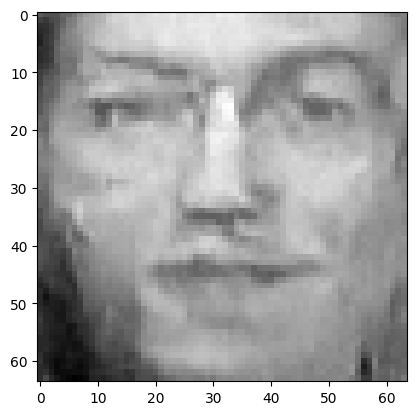

loss(generator):  0.0005666795768775046
tensor([[3.2703e-05, 4.3622e-10, 9.9943e-01, 1.7362e-06, 4.5580e-10, 1.0433e-10,
         4.0537e-05, 5.0118e-06, 3.5465e-08, 1.6244e-05, 4.9295e-09, 3.1290e-07,
         8.5305e-06, 2.6316e-06, 3.3498e-13, 7.9736e-09, 1.4817e-05, 2.0651e-12,
         5.5274e-08, 1.1318e-08, 5.6800e-05, 2.8430e-06, 1.9169e-08, 1.7760e-08,
         8.3539e-08, 2.8340e-07, 1.7532e-08, 1.6893e-04, 1.1145e-05, 1.0934e-10,
         9.2416e-09, 5.7361e-12, 1.0428e-07, 2.5868e-09, 4.2834e-07, 2.0612e-10,
         9.4124e-05, 2.9056e-05, 3.6197e-07, 7.9687e-05]],
       grad_fn=<SoftmaxBackward>)


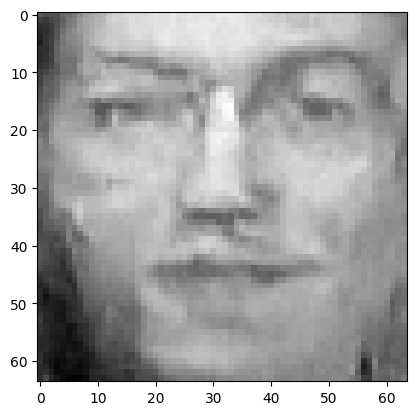

loss(generator):  0.0004970983718521893
tensor([[2.9507e-05, 3.4614e-10, 9.9950e-01, 1.5344e-06, 3.6883e-10, 9.0900e-11,
         3.5685e-05, 4.7692e-06, 2.9225e-08, 1.4883e-05, 4.0914e-09, 2.6742e-07,
         7.1042e-06, 2.2306e-06, 2.5545e-13, 6.7834e-09, 1.2888e-05, 1.5881e-12,
         4.7317e-08, 9.6331e-09, 4.9665e-05, 2.4158e-06, 1.6395e-08, 1.4736e-08,
         6.6826e-08, 2.5156e-07, 1.4588e-08, 1.4882e-04, 9.5230e-06, 8.5497e-11,
         7.1692e-09, 4.4711e-12, 8.5921e-08, 2.0890e-09, 3.6324e-07, 1.6611e-10,
         8.2712e-05, 2.4843e-05, 2.9956e-07, 6.8999e-05]],
       grad_fn=<SoftmaxBackward>)


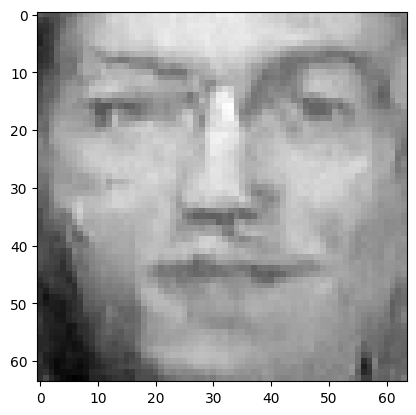

loss(generator):  0.00044264530879445374
tensor([[2.6925e-05, 2.8203e-10, 9.9956e-01, 1.3744e-06, 3.0545e-10, 8.0331e-11,
         3.1866e-05, 4.5619e-06, 2.4607e-08, 1.3768e-05, 3.4667e-09, 2.3239e-07,
         6.0524e-06, 1.9267e-06, 2.0077e-13, 5.8800e-09, 1.1383e-05, 1.2566e-12,
         4.1191e-08, 8.3512e-09, 4.4094e-05, 2.0920e-06, 1.4248e-08, 1.2495e-08,
         5.4828e-08, 2.2584e-07, 1.2397e-08, 1.3297e-04, 8.2920e-06, 6.8810e-11,
         5.7276e-09, 3.5797e-12, 7.2441e-08, 1.7296e-09, 3.1376e-07, 1.3726e-10,
         7.3760e-05, 2.1619e-05, 2.5347e-07, 6.0751e-05]],
       grad_fn=<SoftmaxBackward>)


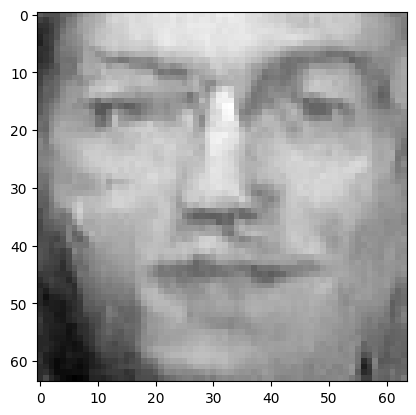

loss(generator):  0.00039915222441777587
tensor([[2.4755e-05, 2.3462e-10, 9.9960e-01, 1.2449e-06, 2.5754e-10, 7.1671e-11,
         2.8787e-05, 4.3778e-06, 2.1079e-08, 1.2826e-05, 2.9872e-09, 2.0463e-07,
         5.2417e-06, 1.6886e-06, 1.6176e-13, 5.1676e-09, 1.0179e-05, 1.0164e-12,
         3.6367e-08, 7.3473e-09, 3.9656e-05, 1.8406e-06, 1.2541e-08, 1.0782e-08,
         4.5900e-08, 2.0473e-07, 1.0710e-08, 1.2021e-04, 7.3304e-06, 5.6648e-11,
         4.6852e-09, 2.9283e-12, 6.2194e-08, 1.4613e-09, 2.7512e-07, 1.1564e-10,
         6.6600e-05, 1.9078e-05, 2.1840e-07, 5.4154e-05]],
       grad_fn=<SoftmaxBackward>)


In [26]:
optimize_ddpm_noise_eps(x_i, 10, 100, 1, target=2)

In [27]:
torch.save(x_i, 'attack2.pt')

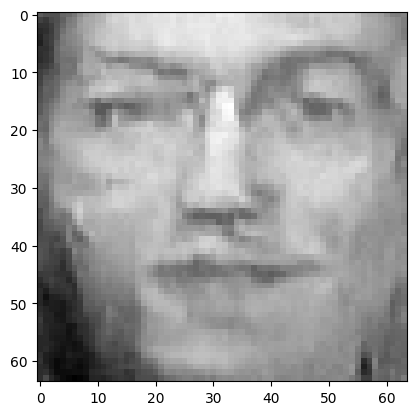

loss(generator):  0.0003631647559814155
tensor([[2.2921e-05, 1.9836e-10, 9.9964e-01, 1.1373e-06, 2.2047e-10, 6.4586e-11,
         2.6252e-05, 4.2157e-06, 1.8311e-08, 1.2025e-05, 2.6086e-09, 1.8221e-07,
         4.5981e-06, 1.4970e-06, 1.3286e-13, 4.5964e-09, 9.1902e-06, 8.3782e-13,
         3.2468e-08, 6.5388e-09, 3.5996e-05, 1.6380e-06, 1.1160e-08, 9.4278e-09,
         3.9046e-08, 1.8712e-07, 9.3724e-09, 1.0964e-04, 6.5523e-06, 4.7471e-11,
         3.9013e-09, 2.4385e-12, 5.4139e-08, 1.2531e-09, 2.4408e-07, 9.8946e-11,
         6.0651e-05, 1.7025e-05, 1.9065e-07, 4.8790e-05]],
       grad_fn=<SoftmaxBackward>)


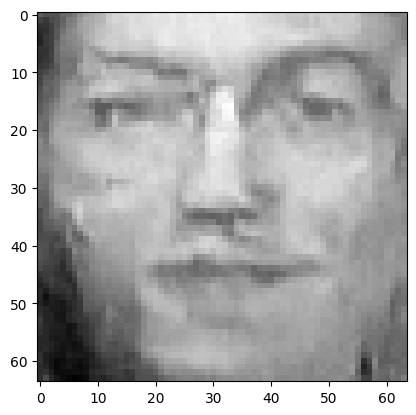

loss(generator):  0.00015054999676067382
tensor([[1.1032e-05, 4.0818e-11, 9.9985e-01, 4.8543e-07, 5.1475e-11, 2.4293e-11,
         1.1268e-05, 2.9565e-06, 4.8950e-09, 6.5562e-06, 7.2717e-10, 6.1680e-08,
         1.3550e-06, 4.8279e-07, 2.0855e-14, 1.5541e-09, 3.4955e-06, 1.3760e-13,
         1.1206e-08, 2.1969e-09, 1.4501e-05, 5.4613e-07, 3.6782e-09, 2.7159e-09,
         8.6065e-09, 7.9961e-08, 2.6754e-09, 4.6032e-05, 2.2713e-06, 9.0787e-12,
         7.0260e-10, 4.3667e-13, 1.4820e-08, 2.9591e-10, 7.9470e-08, 2.3155e-11,
         2.4835e-05, 5.8173e-06, 5.3306e-08, 1.8562e-05]],
       grad_fn=<SoftmaxBackward>)


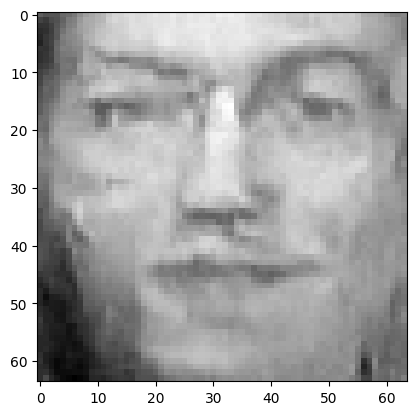

loss(generator):  0.000102037942269817
tensor([[7.3799e-06, 2.0214e-11, 9.9990e-01, 3.3401e-07, 2.4712e-11, 1.3574e-11,
         7.6102e-06, 2.3673e-06, 2.6486e-09, 4.7484e-06, 4.0944e-10, 3.5791e-08,
         7.8670e-07, 2.8826e-07, 9.1531e-15, 9.1048e-10, 2.2550e-06, 5.5421e-14,
         6.9088e-09, 1.3530e-09, 1.0014e-05, 3.5296e-07, 2.0935e-09, 1.5751e-09,
         4.3017e-09, 5.1705e-08, 1.5233e-09, 3.1721e-05, 1.4966e-06, 4.3381e-12,
         3.3362e-10, 1.9217e-13, 8.4948e-09, 1.6204e-10, 4.7565e-08, 1.1781e-11,
         1.7493e-05, 3.5614e-06, 3.1629e-08, 1.1528e-05]],
       grad_fn=<SoftmaxBackward>)


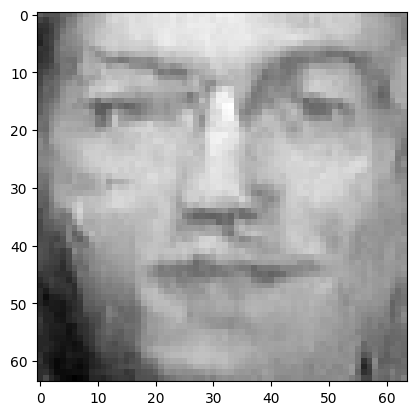

loss(generator):  7.784063927829266e-05
tensor([[5.6289e-06, 1.2384e-11, 9.9992e-01, 2.5540e-07, 1.5098e-11, 9.2390e-12,
         5.8277e-06, 2.0437e-06, 1.7398e-09, 3.8409e-06, 2.7408e-10, 2.4763e-08,
         5.4000e-07, 2.0047e-07, 5.1272e-15, 6.4015e-10, 1.6542e-06, 3.0058e-14,
         4.9454e-09, 9.6664e-10, 7.6802e-06, 2.5841e-07, 1.4091e-09, 1.0788e-09,
         2.6715e-09, 3.7988e-08, 1.0295e-09, 2.4268e-05, 1.1101e-06, 2.6310e-12,
         1.9829e-10, 1.0934e-13, 5.7927e-09, 1.0558e-10, 3.3295e-08, 7.4307e-12,
         1.3438e-05, 2.5455e-06, 2.1744e-08, 8.4461e-06]],
       grad_fn=<SoftmaxBackward>)


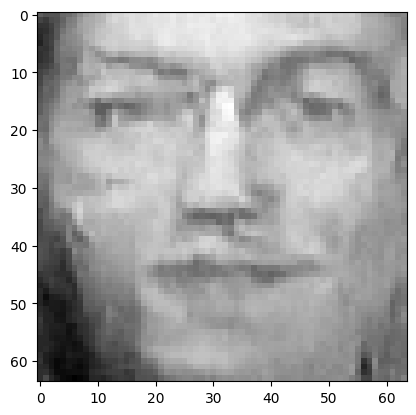

loss(generator):  6.305972783593461e-05
tensor([[4.5358e-06, 8.4483e-12, 9.9994e-01, 2.0708e-07, 1.0264e-11, 6.8062e-12,
         4.7367e-06, 1.8190e-06, 1.2536e-09, 3.2577e-06, 2.0040e-10, 1.8536e-08,
         4.0216e-07, 1.5036e-07, 3.2643e-15, 4.8805e-10, 1.2949e-06, 1.8609e-14,
         3.8203e-09, 7.4670e-10, 6.2499e-06, 2.0295e-07, 1.0278e-09, 8.0595e-10,
         1.8391e-09, 2.9662e-08, 7.5742e-10, 1.9665e-05, 8.8110e-07, 1.7891e-12,
         1.3209e-10, 7.0137e-14, 4.3075e-09, 7.5637e-11, 2.5213e-08, 5.2019e-12,
         1.0899e-05, 1.9548e-06, 1.6236e-08, 6.6438e-06]],
       grad_fn=<SoftmaxBackward>)


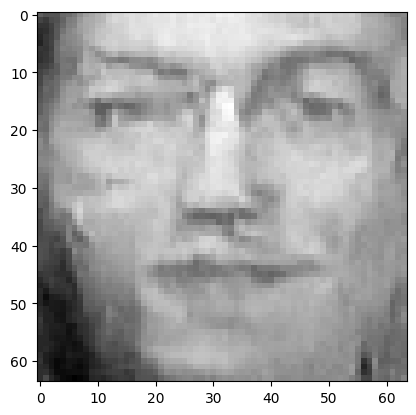

loss(generator):  5.280832192511298e-05
tensor([[3.7629e-06, 6.1532e-12, 9.9995e-01, 1.7453e-07, 7.3868e-12, 5.2099e-12,
         3.9786e-06, 1.6378e-06, 9.5095e-10, 2.8208e-06, 1.5440e-10, 1.4522e-08,
         3.1404e-07, 1.1859e-07, 2.2433e-15, 3.8610e-10, 1.0566e-06, 1.2351e-14,
         3.0855e-09, 6.0066e-10, 5.2800e-06, 1.6674e-07, 7.8852e-10, 6.3152e-10,
         1.3458e-09, 2.4182e-08, 5.8814e-10, 1.6560e-05, 7.2811e-07, 1.2902e-12,
         9.4372e-11, 4.8453e-14, 3.3573e-09, 5.7506e-11, 1.9904e-08, 3.8452e-12,
         9.2192e-06, 1.5662e-06, 1.2767e-08, 5.4001e-06]],
       grad_fn=<SoftmaxBackward>)


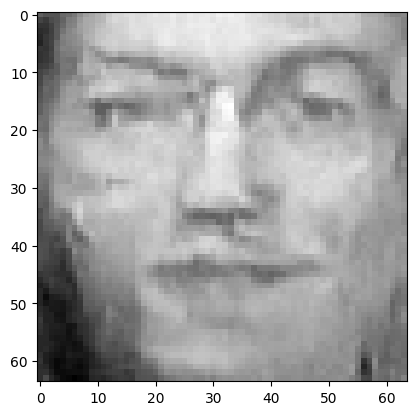

loss(generator):  4.565611743601039e-05
tensor([[3.2169e-06, 4.6968e-12, 9.9995e-01, 1.5080e-07, 5.6046e-12, 4.1704e-12,
         3.4345e-06, 1.5018e-06, 7.5284e-10, 2.5010e-06, 1.2362e-10, 1.1835e-08,
         2.5448e-07, 9.6872e-08, 1.6304e-15, 3.1747e-10, 8.8782e-07, 8.7605e-15,
         2.5747e-09, 4.9941e-10, 4.5727e-06, 1.4074e-07, 6.2978e-10, 5.1383e-10,
         1.0332e-09, 2.0336e-08, 4.7414e-10, 1.4283e-05, 6.1785e-07, 9.7864e-13,
         7.0852e-11, 3.5427e-14, 2.7170e-09, 4.5463e-11, 1.6295e-08, 2.9788e-12,
         7.9670e-06, 1.2979e-06, 1.0388e-08, 4.5422e-06]],
       grad_fn=<SoftmaxBackward>)


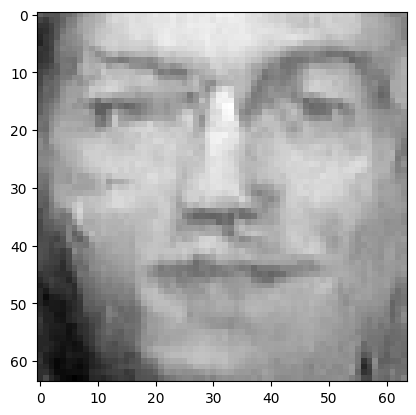

loss(generator):  3.981510963058099e-05
tensor([[2.8044e-06, 3.7056e-12, 9.9996e-01, 1.3261e-07, 4.3967e-12, 3.4296e-12,
         3.0200e-06, 1.3921e-06, 6.1335e-10, 2.2512e-06, 1.0169e-10, 9.8882e-09,
         2.1163e-07, 8.1073e-08, 1.2313e-15, 2.6749e-10, 7.6205e-07, 6.4803e-15,
         2.1971e-09, 4.2452e-10, 4.0284e-06, 1.2126e-07, 5.1672e-10, 4.2872e-10,
         8.1946e-10, 1.7455e-08, 3.9250e-10, 1.2543e-05, 5.3511e-07, 7.6776e-13,
         5.5082e-11, 2.6907e-14, 2.2566e-09, 3.6969e-11, 1.3665e-08, 2.3799e-12,
         7.0048e-06, 1.1008e-06, 8.6659e-09, 3.9059e-06]],
       grad_fn=<SoftmaxBackward>)


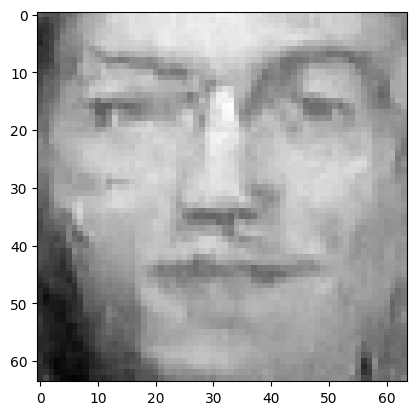

loss(generator):  3.564294092939235e-05
tensor([[2.4751e-06, 3.0185e-12, 9.9996e-01, 1.1861e-07, 3.5593e-12, 2.8733e-12,
         2.7033e-06, 1.2947e-06, 5.1278e-10, 2.0440e-06, 8.5796e-11, 8.4733e-09,
         1.8000e-07, 6.9710e-08, 9.6426e-16, 2.2913e-10, 6.6764e-07, 4.9614e-15,
         1.9177e-09, 3.6687e-10, 3.6092e-06, 1.0671e-07, 4.3466e-10, 3.6529e-10,
         6.7148e-10, 1.5391e-08, 3.3444e-10, 1.1239e-05, 4.7001e-07, 6.1872e-13,
         4.4482e-11, 2.1297e-14, 1.9124e-09, 3.0929e-11, 1.1657e-08, 1.9496e-12,
         6.2788e-06, 9.5294e-07, 7.4067e-09, 3.4162e-06]],
       grad_fn=<SoftmaxBackward>)


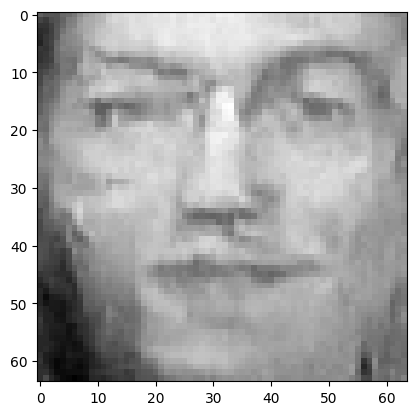

loss(generator):  3.218599158572033e-05
tensor([[2.2104e-06, 2.5061e-12, 9.9997e-01, 1.0721e-07, 2.9384e-12, 2.4468e-12,
         2.4455e-06, 1.2124e-06, 4.3592e-10, 1.8727e-06, 7.3527e-11, 7.3677e-09,
         1.5545e-07, 6.0790e-08, 7.7245e-16, 1.9915e-10, 5.9224e-07, 3.8949e-15,
         1.6953e-09, 3.2136e-10, 3.2674e-06, 9.5021e-08, 3.7150e-10, 3.1606e-10,
         5.6059e-10, 1.3730e-08, 2.8927e-10, 1.0174e-05, 4.1788e-07, 5.0867e-13,
         3.6644e-11, 1.7227e-14, 1.6461e-09, 2.6306e-11, 1.0093e-08, 1.6270e-12,
         5.6851e-06, 8.3605e-07, 6.4246e-09, 3.0255e-06]],
       grad_fn=<SoftmaxBackward>)


In [28]:
optimize_ddpm_noise_eps(x_i, 10, 1000, 1, target=2)

In [29]:
torch.save(x_i, 'attack2.pt')

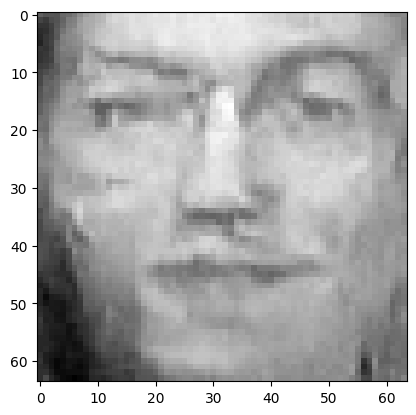

loss(generator):  2.932505594799295e-05
tensor([[1.9926e-06, 2.1136e-12, 9.9997e-01, 9.7722e-08, 2.4657e-12, 2.1132e-12,
         2.2317e-06, 1.1425e-06, 3.7589e-10, 1.7297e-06, 6.3869e-11, 6.4794e-09,
         1.3592e-07, 5.3587e-08, 6.3060e-16, 1.7540e-10, 5.3053e-07, 3.1227e-15,
         1.5147e-09, 2.8493e-10, 2.9818e-06, 8.5445e-08, 3.2157e-10, 2.7698e-10,
         4.7517e-10, 1.2353e-08, 2.5322e-10, 9.2850e-06, 3.7542e-07, 4.2562e-13,
         3.0672e-11, 1.4181e-14, 1.4358e-09, 2.2680e-11, 8.8502e-09, 1.3798e-12,
         5.1861e-06, 7.4172e-07, 5.6408e-09, 2.7090e-06]],
       grad_fn=<SoftmaxBackward>)


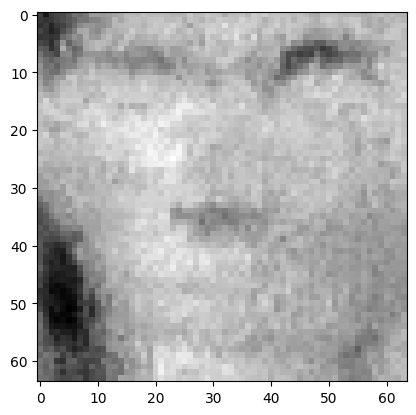

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


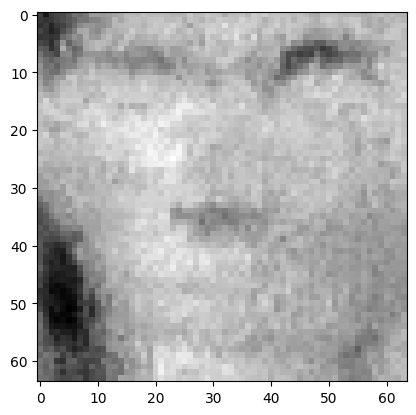

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


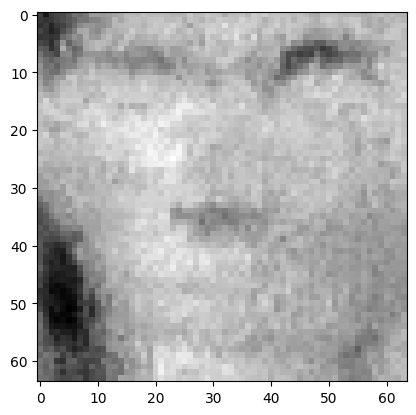

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


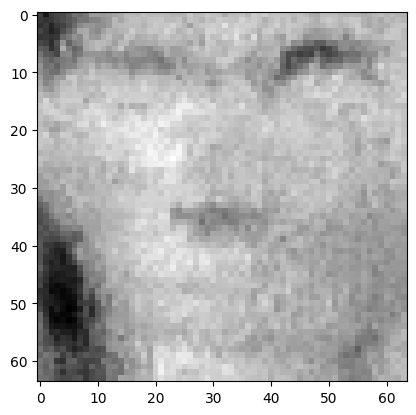

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


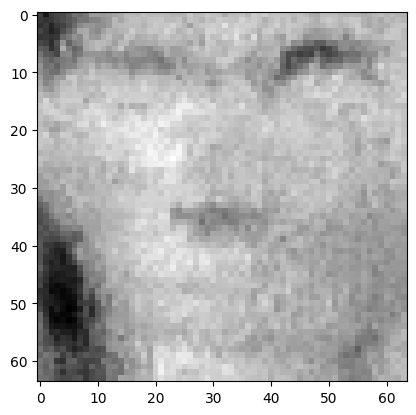

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


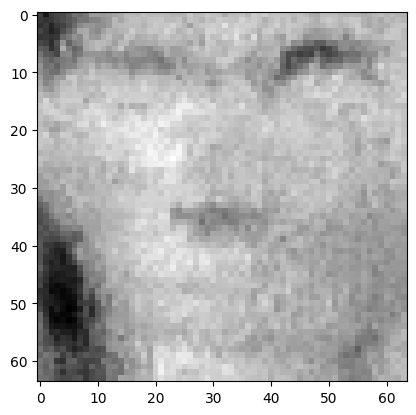

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


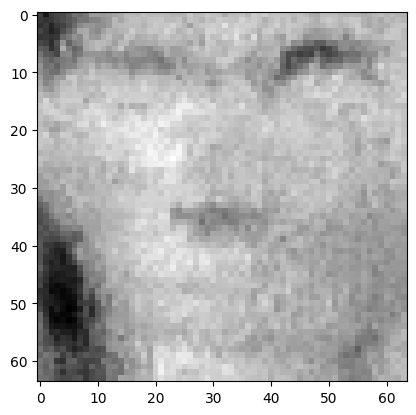

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


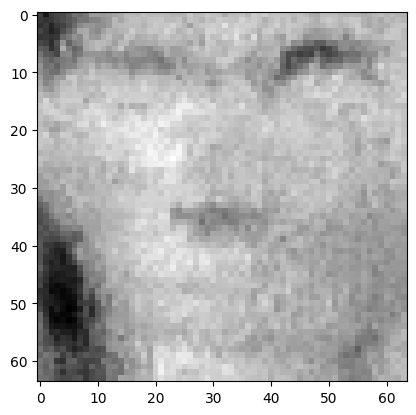

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


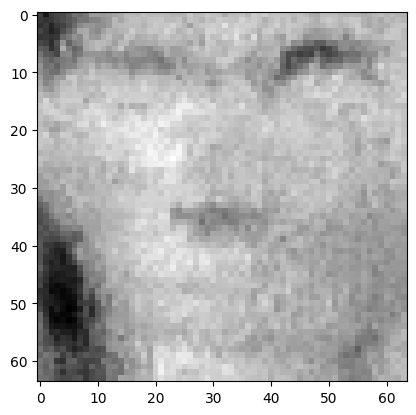

loss(generator):  0.0
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<SoftmaxBackward>)


In [30]:
optimize_ddpm_noise_eps(x_i, 10, 10000000, 1, target=2)